In [1]:
#!pip install git+https://www.github.com/keras-team/keras-contrib.git

In [2]:
#!pip install dataloader

In [3]:
#!pip install imageio

In [4]:
#!pip install matplotlib
#!pip install scipy
#!pip install skimage

In [5]:
# import os
# import shutil
# # folder path
# dir_path = r'./datasets/youngOld/other'

# # list to store files
# res = []

# # Iterate directory
# index = 0
# for path in os.listdir(dir_path):
#     full_path = dir_path + '/' + path
    
#     for old_image_path in os.listdir(full_path):
#          if os.path.isfile(os.path.join(full_path, old_image_path)):
#                 shutil.copyfile(os.path.join(full_path, old_image_path), os.path.join(r'./datasets/youngOld/testA', old_image_path))
         
#          else:
#                 actor_full_path = os.path.join(full_path, old_image_path)
#                 for young_image_path in os.listdir(actor_full_path):
#                     shutil.copyfile(os.path.join(actor_full_path, young_image_path), os.path.join(r'./datasets/youngOld/testB', young_image_path))
            
#     res.append(full_path)
#     # check if current path is a file
# #     if os.path.isfile(os.path.join(dir_path, path)):
# #         
# #         os.rename(dir_path + '/' + path, dir_path + '/' + str(index) + '.jpg')
# #         index = index + 1
# #         print(dir_path + '/' + path)
# #         print(dir_path + '/' + str(index) + 'jpg')
# print(res)

In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

In [7]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

In [8]:
#@title
import scipy
import imageio
from glob import glob
import numpy as np
from skimage import io, transform

class DataLoader():
    def __init__(self, dataset_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                img = transform.resize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = transform.resize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path_A = glob('./datasets/%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob('./datasets/%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = transform.resize(img_A, self.img_res)
                img_B = transform.resize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def imread(self, path):
        return imageio.imread(path, mode='RGB').astype(np.float)


In [9]:

from __future__ import print_function, division
import scipy
from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os

In [10]:
class CycleGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'youngOld'
        # Use the DataLoader object to import a preprocessed dataset
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))

        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 64

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.9 * self.lambda_cycle    # Identity loss

        optimizer = Adam(0.0002, 0.5)
        
        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])
        self.d_B.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[valid_A, valid_B,
                                       reconstr_A, reconstr_B,
                                       img_A_id, img_B_id])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                              loss_weights=[1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id],
                              optimizer=optimizer)


In [11]:
class CycleGAN(CycleGAN):
    @staticmethod
    def conv2d(layer_input, filters, f_size=4, normalization=True):
        """Discriminator layer"""
        d = Conv2D(filters, kernel_size=f_size,
                   strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if normalization:
            d = InstanceNormalization()(d)
        return d
      
    @staticmethod
    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
        """Layers used during upsampling"""
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
        return u


In [12]:
class CycleGAN(CycleGAN):
    def build_generator(self):
        """U-Net Generator"""
        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = self.conv2d(d0, self.gf)
        d2 = self.conv2d(d1, self.gf * 2)
        d3 = self.conv2d(d2, self.gf * 4)
        d4 = self.conv2d(d3, self.gf * 8)

        # Upsampling
        u1 = self.deconv2d(d4, d3, self.gf * 4)
        u2 = self.deconv2d(u1, d2, self.gf * 2)
        u3 = self.deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4,
                            strides=1, padding='same', activation='tanh')(u4)

        return Model(d0, output_img)
     

In [13]:
class CycleGAN(CycleGAN):
    def build_discriminator(self):
        img = Input(shape=self.img_shape)

        d1 = self.conv2d(img, self.df, normalization=False)
        d2 = self.conv2d(d1, self.df * 2)
        d3 = self.conv2d(d2, self.df * 4)
        d4 = self.conv2d(d3, self.df * 8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

In [14]:
class CycleGAN(CycleGAN):
      def sample_images(self, epoch, batch_i):
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)
        
        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        
        print('FAKE A')
        print(fake_B.shape)
        
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                
#                 print(gen_imgs[cnt].shape)
                
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("datasets/%s/results/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.show()
     

In [15]:
class CycleGAN(CycleGAN):
      def train(self, epochs, batch_size=1, sample_interval=50):
        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)


        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ----------------------
                #  Train Discriminators
                # ----------------------

                print(imgs_A.shape)
                print(imgs_B.shape)
                
                # Translate images to opposite domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total discriminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)

                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                      [valid, valid,
                                                       imgs_A, imgs_B,
                                                       imgs_A, imgs_B])
                # If at save interval => plot the generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

/tmp/ipykernel_4325/1911275752.py:72: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return imageio.imread(path, mode='RGB').astype(np.float)
/tmp/ipykernel_4325/1911275752.py:72: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return imageio.imread(path, mode='RGB').astype(np.float)


(128, 128, 128, 3)
(128, 128, 128, 3)
1/1 [==============================] - 0s 84ms/step
FAKE A
(1, 128, 128, 3)
1/1 [==============================] - 0s 11ms/step


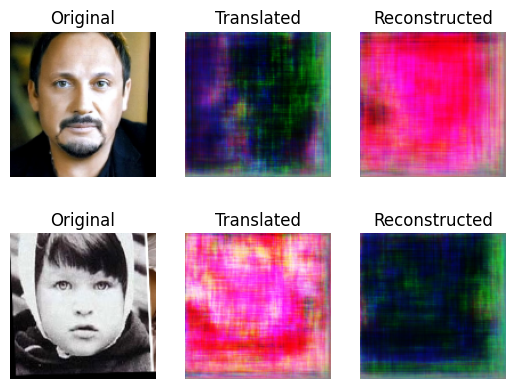

(128, 128, 128, 3)
(128, 128, 128, 3)
4/4 [==============================] - 0s 8ms/step
(128, 128, 128, 3)
(128, 128, 128, 3)
4/4 [==============================] - 0s 7ms/step
(128, 128, 128, 3)
(128, 128, 128, 3)
4/4 [==============================] - 0s 7ms/step
(128, 128, 128, 3)
(128, 128, 128, 3)
4/4 [==============================] - 0s 7ms/step
(128, 128, 128, 3)
(128, 128, 128, 3)
4/4 [==============================] - 0s 7ms/step
(128, 128, 128, 3)
(128, 128, 128, 3)
4/4 [==============================] - 0s 7ms/step
(128, 128, 128, 3)
(128, 128, 128, 3)
4/4 [==============================] - 0s 7ms/step
(128, 128, 128, 3)
(128, 128, 128, 3)
4/4 [==============================] - 0s 7ms/step
(128, 128, 128, 3)
(128, 128, 128, 3)
4/4 [==============================] - 0s 7ms/step
(128, 128, 128, 3)
(128, 128, 128, 3)
1/1 [==============================] - 0s 12ms/step
FAKE A
(1, 128, 128, 3)
1/1 [==============================] - 0s 11ms/step


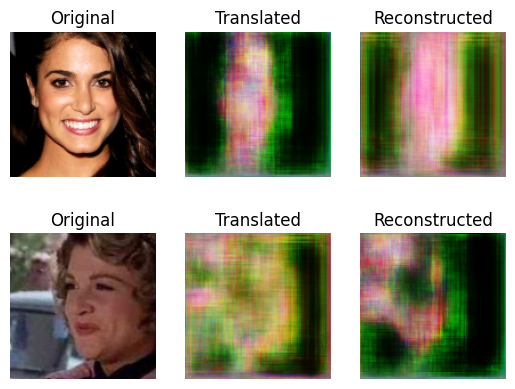

(128, 128, 128, 3)
(128, 128, 128, 3)
4/4 [==============================] - 0s 7ms/step


In [16]:
cycle_gan = CycleGAN()
cycle_gan.train(epochs=1, batch_size=128, sample_interval=10)

In [17]:
# cycle_gan.d_A.save("discriminator_A")
# cycle_gan.d_B.save("discriminator_B")
# cycle_gan.g_AB.save("generator_AB")
# cycle_gan.g_BA.save("generator_BA")
# cycle_gan.save("cycle_gan")

In [18]:
import tensorflow as tf

discriminator_A = tf.keras.models.load_model('discriminator_A')
discriminator_B = tf.keras.models.load_model('discriminator_B')
generator_AB = tf.keras.models.load_model('generator_AB')
generator_BA = tf.keras.models.load_model('generator_BA')

cycle_gan = CycleGAN()
cycle_gan.d_A = discriminator_A
cycle_gan.d_B = discriminator_B
cycle_gan.g_AB = generator_AB
cycle_gan.g_BA = generator_BA

In [19]:
image = "iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAIAAAAiOjnJAAAAB3RJTUUH4QQMCxohXot+mwAAIABJREFUeJxcvW2S5EiOLKgKwIz0yKqe6R2R3SPs/tp77P2P8Z686TddGeGk4WN/gGREj0tKSWaUO500gwEKhQLB//f//v9ERAoEM6Kqtm3bxqhKZNrQqsrMMQZJgPu2R2Z4VJWIUKRQBYipiJAEUFX9qcw8juP9frt7hKc7K0X48fFB8jgOFghUpqmaGsnMZFX6qYC7//r4MDOSlYUsFa0qM5uvvbKinBKJyGSGRPRX575vf/3+L3dXGWa7cPhxfmz62kxUIxbAv/3tb6/X/vX19fHxqkozm9P6zj9+vSJ82/aqWmuZWVXu+y4iJKpQlSSJggcBCoVCg0BXnBEx5pj7NLEiABQKgKqA7L9s2wYgIjKzn3qt5eERAaIox3HE6Rl1Hh5Rv//6VOi+vVTt91+/z7U+/txeHzspa7monef6n//rP//r8+t//Of/OrKCfGcUGYn0EppIVZUaPdf7eP/tzz9///48Tx9jm3NfHu/1xS0TmUF3VAoxRJSkCCKOqBNwSpqa5jzPJYoIz/Q5TVUBZFYVhNMAZGZGmllV9aOKiNk832+CEUlKJT1i3/e1vKpI9oVIFtk2BKB/IiJtXr1e53m6e2aocNjIjPM8+7tYEHKYiWhmRiQJU8uoc502TNRMR0YKYENVZI4pIl/nOyq3fROTpPrCyuxHAfL9/spMUxUhMjySYBW+vg4RoWDOsdb6+vzcts1PX2u5/3PbNjPb91lVX19f7m5mJLZtZKaZVhUAEhSiKCyZZnY9rA4ViIBm1ocBRAEEstLdReVZNwAg1DTOIDG3QUUdGelZpaCBokYlS74+3x/7i1nDZAxb09RERKpKhCIipKrObdpxqipiiYpCIKrC008TQUVWsUSKSqksERk2VCTcBXxt28E3CiKy75MYGYzI4zjmHNu2e2KtIEkhS9x9t6lzuqOqjuOYc2ZmFQp+GdZQJdlOSEQ84v1+TzNSq+KxmD7BpKgKQBEhhUIASfx8icgYY63l7hFRVaSIMDOr6jzPzDQzUgCMMVlwdyTEhKWihvACPXMUALSvMNU5R1WaqlFVSEpWRkZE+orMrIoMV5VhUoUMR8m+fzDjeB+quu8bEn6u8zxVxFXd1+/fv0mqsKr+5//8H0B9fdXf//5/jDHc19f7a4y/Uwpop3ydn6Fmw9pHi6qqiKqZ8nbeWZURmbntO4FCXQZK9FIc59vM9tduwyoTVRmJYom2e0uvGiMU4VEoCOe+AYQk2XdTWUVym3POOcc4I1NUCkmgQFApWZmZBhXAKO/fn2I69909fv/+9Mj9Y8eECAkBmB5rZSYyE6hC9rECWMnzPElRs6owGyL1z3/+c85JtuGJqeqcE5EA+siKCKrajKr61tkrWR32UBGZWX34qtrJ46f9tQl+fX2ttVSVdwjw4z2GiSiAbUyhZvi0LZYbimOoamVRh7wkwzMzwglQREVUCJSovF47gMPX8T7f5+d5+DqTUFJVmQAqM+DuykGgwlVExYapqa3TgZpjhPs6j2H2H3//+8fHa63jPN+VOXczHaIAy2OpUhQivEMDRUSEcw4QqKKQIqY69/3r85PANFPTyAxfmfnnH7/WWh5h92q8j3esaAt8f31WJoFh6ok5Roh9vd/uTsLmkCLomVnAmEOoxYiMC3hkFGBq+769Xq8z66zMFZ5ACQABqlARqEFQwARMtJHDnPPX3Ir1GafDiQJQSVJFYKZAZVZHqvb97mvfXyJyHEdVjqHbtolIVWZWVNgYY4xxvN/pQcrt7dm4KzMB9kK0730iYP8wIjxif219vK7AmpmZn5+fn5+fVTXnzKrj/c4xFCJs3FYCMdEohGdEEiKiADMjIiGR5RnEsDnmPuY0M7WozMzlfp5nVJ5+vM83imZmHKJDpMyZ5RUR7nMbWfn1+fu1vV6vzVTN9OO1bXO6e6SbCon3+9P9pMCGzc1QaUMjlgjNdNteDSNERFW0nVN75XQCYm1wIiaJNFUqIEVCKQKZ25YAVOYYx/E+z7Mj1Ou1N1pLoF17VVFVKOIqQKGyXCGpV8ztw59ZMhqoMKL3vcxsmxs/vzIuBCAilGu7WCCRCTNjynmex4p93xsFnetc6UEnSiiAgkWgg1lmViYgAKv4+vglZN7ffhxr3/eqyoxMVJVl5vv9Tg9UZWUb1vVqGHTbEG/TIS8YkVlrrcx0d2jfPjIzIvqDbeMRudzFjCIVhWJVVdY6vRQUZgTqMtY+GqrqsQTSK/Xxem1qnQpkZWSSHGPUeaJqqpkNs904sphxQlOrVroJxlChYco+X9MsI0xlm1NVREx0qEpEuHNOG9NU1aauOMk6z2Wm+/7x8fF6vV5yv/S2rMZAQtGhBCIz0l9/vG5AlqoUsaqKCpvKgJjEV0RGRGz7vNxCIdx7ebfN2t+L6BhCJIC1Ehd4rbZgj9PEeq0y4WtFZGYAyIxwr0qIiBCQ8zw7HQEa8JBEkWMOiqwVYBZoav1+QFCsygL6Sxs8iUpbz3zN33/9BvLXH6+vrzpPf7wPKaTY+/0mOcdAFutC3AQyEwUVubxX1ZPx9SczUQVS5pxVEe5GKSWqyPzHP/6zAa9HLV8e4eGvbd/MMquyBMzMKB9jdAJZ31+EMQy0MXQb04YJudY6juO17QiIybZvY47Pry/5Sg9RNRVDSXlmZJynKEzltX+oCsF9vvbtle60MefYts1Go96sKpHtjz9fHx+vTD+Ok+zTlXPavm/7vrUxbdvWq3FZlUgwpoqpUViVjKqFhvwkbZiIRPha/l5vUUt3kGq290UalVFQRQCEpSntOA4ggQKoKtv26x//+CdZFEZWIUWtziu2qGoV1lrhHhkqss35tdbPLIpCKfGMKpAookRsWhaz0jMAqI459pSI7NN9eZd7NapRe6IyYrm7O5B90sxMVVUbVZdQ7PV6HcdBUlQuAFVVQHVWne1IpGOiiAJpppm5VgdXM1WKRuU+x9fxrkoVBbKqPj8/l+frtYsAnlkpOtKdWTZG+ycRVmVWSCGbL8jiaAxDoHytBUpVRfyf//Efv78+PSIz//rnXxExx0aUjVHB8zwzyaKqqPD1sZtpeKrar9drm7uv1VY15lDlGAZkhM85gTKVz6+zMtTkzz//eH28tm0bP16d61GoqpSClKBsmCozIytEa7dxZY6X/46spJBVc87e7Qa5ZtZcA6sKoHKoEZJeDXzd/TgWRcY0NSZYycrISlGhSOfvACPan9Go+7Zv861fX8MsVd3TPfexUWTFGR42tQiPoJBEgmKa7U4KERWd45dcYauuLIJCkYHMyrVOb6uNiAhf63T3bXutFRnglJtiMBtmGdlE0B0LWcWqBu/tnygCEVTVGIpiVcTysakSYCrx+32I2L5t7/c706sycpmqfWwAolZlSsFMlYwACTUFClki0sQEYCIEL15KRT62rfbXf/7nf27bNlR+n0dVjKGZ+Xp9mNr7a1UmCsNsH38OhQ4IoZvOue1zVx3Yx75v29xUhSw1FYKECL/eX8vPqvj42PZf+9z3/fXatk1VM+PXH79IoYBKNYgAUoWYw8w0M1ApAoAgLmBPdkoIkTEUK1WlyjKiUCSoIEB0QlQkOkeO9GKpCcUSyISnjzl675kUlcjYXvu0hgdn+60xBjI9Q4SqqlnZWLqqADWL8sgswDPPdZJUGxARlSRE1dPfx3nRcmzXUoVSUQAsIaBiSl2n7/uuKmxorEoqKSrsLNgAzDlvbvOyqvbzKGbfXCWFUS6gx4r0oaoqVRlR0qgTpQFA3CNimQ0AZiaalUGT3qFYwSiI3n5eSXTEL6SZEHKmR8TcbM4xVU1kmAK1b8MoOuw4T6I6mNucf/zxsc7Is2rbUDTVuY99k6wF5JzTbA4b+/YK99c25zaFLAQAkRpjAtXpz77/+Xq9to9dxhhzdkIcUZSi5JhGIwVX4it1cbNVEBLs/wGy7pSn45HZyFju62FEC5hzeif0TXYVIrOijSEiwmx8fIzzXOfpavrxx8fn5zFF59wicpuzIiL6KWhmVciIKjfVYePt7suzqi2GojRlZQEeERFqtjJYBcjNoBBgJydCeEaEAzV1o43jvdb73F+/ho73eq9zHeVzUzMD8jw93EUGGZlpzaq7ezKzqjJVFWAVwsPMaOLppk1gehOfBVY1wwEzA3msIyLX8so6j0NEM6MQHZvJOs+vqhq0jrfn8RZyzCEpCRIQVTNDVSdCay2R/Nuvfx9q8KjKdZ4lmpmVMcyYIiJzThP1cjPbtxdKMtcYqpL7fL32rZAZGMOGmZA2dIw+FZ2Dx5iiZiXR4H1uU+eISGmenCWqhVC1YlalQMDmG1AFr7xB63fV4Umc60IX+TikxmcRMeYsIM+TSl40dYS7iIxhYhoRlSWmElnIMTaR0RRgZvSfTiRVbUAyq5ajSs1UFRdcJoXuQToIqnTeABUZ5plXOBbtNd+3QYGvRRVkIFNUY0Wzj0i4nkBnpszAWi5iFx9eaSIikhnmKwC6+1RlU5+iTWaOfa5Y2knBVaJpL19V5eERiyTHsDGO8wzP4zhRRPE8zsyoyGOdr9dG1vJDIDK1BEAex6qqD36IDSFVZIxBQAr7nKJiQ15zhLtkTRsmWhGFcncAcwzJzCozXeeKtVTste2knifVoCZz2JhKmlBVp4jObWzbmHOoGdn+QeY+5z7tJWoy9zHn9HCeaEAKZlZSRE0LzeB3ILvKO+HZVvVY0sMzN56ITI+AYIx5ORjwPM/IBFDXwYNSSKuhlVVRElciRrJBbWbYEA+c54qI82QnWyRVBZTzXB4O4i48QUWyQxpwLqcUjVkZVSJWkMokJSPTA4WqjPIxbR1fqdYZq4p+fn4CrMrO1gHMOdxdRKs8ItrUtrldVBdg2/aKWACO4wAwdFzYHczmWvEdIvvAEe3asrFXZGItkhm11lUROo9DVRxQgYgQNcxUBI3SIGoyxhBhRZYI5N4VFMlptu/ThkS4FGBX5kiRa2tBstLXuaAN1kUbac451bhtYgNVqcoxhqqNuZnpGGbD1ESMNnVs4+vrS6cNtaqyIVQSbHQlIoWMjOrijEhdkAgkKVJX1fCbjrnQvWi/jyoqLK/MKuRaq0EJBBErKhNJXjjk8nmoqhShKquSTDPtGNrVDjNrZr8iH9covKB2X6Ljo5T0zolweaTH4Mgm/sF9e4XGX3/9VQVRJVFZw4aQzbmqKcCIUNWqEhlmdhX95vj65+fcJtnVlOwSSCVFJIJW1SANUTmadgcys1AsFioiGq0L2YuyzgstktoR6qwqalaiUFEE3f2P18daxx/7h6h4LBOefniuf9v+DYmhpqpd8AEwTFGFSlSpck4bw0SpQqV4uEcqqURlRhWQUc3X0KbObbsoZpFtm2a0AZtUI5iZOQf3X9vYTFQgFBUzVZOSGvsYY1zPKBcq4pWvVF6hrQ0JeVvW7Z/iCoJENv/evHFdIaYZLxDukZk6pNMRG1pZZB/UNgkUCwQLWaFiIkJWf/HYRngVZIhQR0T4co9optTdM0Fi2Dj8nZnDbNo84x3Z+VfTZfTKgnTw+vp8R8ScW+ena60nS1MdKqaqEeHur9fHWoukKjMLiKrMSjMTxVpfmSmCz8/POT76QNpaXhUEzQxA+zezQbCiKsvd+9nlwl51nqeq2txIZFZkEjjXCYipnscBZGWEh4rs+/75+RnhZkKg+bPK3jJWRaSLQmQCVZm91mamIsf5HkNFpCLAElpVhTvIJEHMOWVch0FNCBlDPj52sQJjTKWRpBrnttmmMoQios27XA7iIqWatb2tITIzSlXaUfenRAUZK70LFASySuxCGLeIASKSmXe+V9nkr7DLdnjeR4AYd2J+/RCgSFSpQEyYCQqpShbSVzRQa9de6Dz6XMszC1VjmJ7CLKMga9CO8x2Zum+8yKQ+El2LKzMbYzTFnZljWEakh8pQ1ZsIu5yy+6rSQlIqYv369WvOWci1mk6ztbzdGwDr6GbDkO5r9Qn5WdiJvOoFQxXAY9ftEt1PIecYGgXSV7HqfR511cgiluMKF6JiFRA2xY+qK28C7kjIEqLVJSTP82CZWJlolwDDneSYkyIUzm2bc65zhce2mYjMbfz62wTK49ShOlTNVKlm7U5sWBtu+/uOvM0mt8fqhGCVh6dctXm2u1YVCLiizaINQYQFstHQkwcKe33S/VnPS+xAoFjZVkYVvaoUlxSCV4GDpFCUTYpVlbtHpkon46GqnNBiZrqvKkTU+XXuY5z7fpxuogGwsM+NY7zfX/Wjntv7rqpdz3B3VTUbUeLH0XXhCO/Ie+11rMzWaCByjfHRJFZn95cWqHStVYWuFZLEefqDOjsfYVEumsAvOqTKfampitxRrES10bS7h58inMPArCoUMlNF0ZkTUVIejiygmgVRoQk7ISAhlI4OETHHFEFmVtuRUgAl933vXItZ6+tdVf/+7/+mJiTUpJBNz1JoNrZ9U+0o/k2a3xixwLo4p4SImF08MktCUlQLiKzMSE8xbY6qePkMEKcvsvGiPCnhDYnQuKKNLRvb1LW1JUABQpYwkyLNw11A9kZsIlLVpp+q+vF63dcUoGr5/pprnV3PqSoBz/dxcTFq+7advnJd33ybLdpNdkWu970PgFBUrUshEXmrrFJVJaTT20ulkhEBEY4x1nrfGpZGimxPeJ7n4X5uYwwdANbyiJQSNbVh55k3r3+jgar7+SUizuMgGeHuS5RaMEFkoMrXoog0VawiKhlZGYQSRrn4xGv1QXs2PuLj9fJzRUQCUKqOKIjaWqEUERAwNR0mKDNr1Ur7GO0aw/W66KV7n+rGmxB9qiJppqrsEyxUM4PwzukTwHIHy8Zo2cKlJ6lns/CDW74u27vSa9WqmMLNW1WBiIx6CFJpWAdtip+NsQR39ifCc52i2Lbh7lX8Oo8q3PRXRPjKpgaO8ziLCvL99eY2ZFgrUOp+5c01PCW7bKRWgoJaY1Y9z5PEvm82flXlWkfe4sS2pT77IiUiKkrT83SrKvd4spXIqCxVVTWF5l0Svko3vQcZmTXGUJGIFe6ZKZQMr1zUZqK71FzrXGI6xuizmJXI5MPEdq2uOkW43EkXeaoqTgotOwleqay1YpubiCA6mFYzSr06YwwKcUHmWVJ3ztL0uj6Q/AfVhNt7Xfbg7mutbdttG8tdVD/++PV+v1vzlJWXQIioRCIvfvfHZdsBFCCqzy7iZ3X/sjzUrdbq4pWwuY1GVyRpJoAs9ztbupJHUUrpLYmjmUWcTYStiAu0ZTpqnSeAbdsWGiHXcwB6wfvxLz9NVuH9fotQxfpMZeZxvOccc47lp3t7GSE5hpG0UVXR1hERGeEettYC8PHxC4iKQMHM1gozM7XHVfYu9q0k4escl+I0q2rbNmFlHlnRNUwgVVVNIgtCVT1Pz0ylGGm8dMwtsuyDowI1oZTHAmoOO4+1TZs2zUy7aB2dsZNZIhxipNidzN6egq3mO+O8qumozr2/38FLikeputSLqBIALZtey6nqx2Ei2hxJpjyi2W+k8k00tCu64RQ7llx7fG1eP3FddbMEr/wqIcJW0yXcfWor5gpA5oN3eSenlzghKdu+V6Z743q3YRA5/vdfXdDMrDknSBvD1/rpTZ/D8PiOO5Zx33cSmd7vHGP0U0RIJkznmAowAy3cEF4aFqDcU2gALTO7EAvmPkZfettmFd7H29QeoFBy5fMNE9yDiAi/wBc7C/WI1iBSlDZGJNyDxYoCuO37IOtcbO9YLJQIbZqogEgEgTGajAgUWqTCrJYWujvJlsp0Rfm17y2PjIirStzgVJTfL7QRPM6/sQJZEESE2SUEbagR4c/hfgLcZRedXHVNvoMLW1p4cRO8xELxbORl91UQsFCA1OVuBLLwiGwJUkSzinmzEFmXC2wBBOWyMxWgRORci+QlL9DySDM9z4jlJbLPrYC11u0cLl91I2bveN3ycTPb9/19nFUX+uz73/fdTDr7ICk0ACu8Kt0XJc/zBFJ1ALVtW0Qa2fqbArnWEsryrvTRl29zK6nryN2kaBWer+wAfZ7nWm9ysTXVou5rrVS1zDqO9xhTut5buTy2Meacf/31l4m2O3V3lOrgEFVKJt7rkNKuQ6+1FGycCNQwfW3bHFOt1xckI+NWqV8SarErRLY7aCTU9tdndNvGzSLhOT+Pkqy3Hp0IAGgqWND0SqtIL5kyvi/SG9ZV6P6UqYpqRXgEW2tUlDuA8sf3P4egvLKS90moi15nZn3nmG3E0pQpI7LqnRFrrTnne62I8Awvfn19cVizd00VdfWi77P9/e3Fu2iYDWZERlX2BfuonGdHsGadfI7Zh7kVmmOMuF5pvDgcZMHX0QXpzjy3sQ0bgXiAXol0En3ptEARRsDXOs9jTpgpRYW6Tndf7uGeQ0zBziK8ytSq6jgO3npjJatSKSqqYixmeWaZCp4gIvIz7vR/3b2qiNZH4JuFCo/wwSF6q2+uMyD5UyJbFVk/tzYiSb+PTYkIpAnkSlSLPS42qO+BfGLct2PrCGKjASur0r0iUUnRq3JyK57+FfDdKRuqs+kHoskVLu6byYxrQ0QuZe9FsqsIylV122asM8LNLFpF17W7W3NwESKZz2Hrv8853dda6y5QZaYfR/+tE49mVFJVWzqgVpmuqq2BzYQ9tT9Ujderw1hVnuf52l8R0RC4d6YupVbhVi23QmOYbduLWGLMxIqk2m6DN8vTBO6DNAXy9fmlas2XqM1MVzWAvkKKorrtG/ufQrOpZs20t+BzrVVZhRhjbHOqaqXfUL2qroydvLgjEt16gTufvcJBlshPf5MRdbmNLBEpYd55RgegzEwUrpIFMmFNIHcYI9e5MmIbs8iuPSklwfLb3xQe+uax8sfhddnjyeDAK3L1YzxbHREZVZFrLfdsRmBORFQLPjvXdk+vDJSHhz4ZcTVyatfFW+t7JU/GKrpXV5Y6pLQFm1kmVE0o4UW2yB0tgvG1hJpeAm3WuAEISay1BLLWOk8nyCKNT+LQWUOjhYjIS0MdGZFZ+/7hsXyd7vF47+coP34+MyDqHmNsQglPGocOlIQnqkxUBeFZkQJtWw73hpBzDJGubRFoJkPbmalaIxtVndNERfUqIKrKw1k/K1gVdWfy975+x7KsuPQk996rqSiDQCXQKJxMvH9/vT52YdfQU8g5pqrm6u2/SKPMfL1ePz1uX7Zz0hsgR1URVG3y7+K52ls0wL1tKyIqIwDs+5ZZvur9fruXqp7nuc4zIwAdY7zm+Ar/itUkJYBOy9Ar2DlZJq8+hhW5wCSVwjmHe6hKA6S1VlUub3p8nedbdSNSVc9jmcmYu6+0+9wkeMl0qJxzjrGpavdV9YP0BpBdGeWvX79i+efn78wQUkSO4+yt4l0jE5Gvr6/e6S4ZdbhJdIvrIKRl/7ZNs1npBEwE4Ple7v73f/v3dstepaIkPHxQ3UOMNqyZyY4iXQ7qZRrDKKSwiaJM6I0T8cNFPdR/ZjbeeizPIxKp0PYf2ki/gLqrb0V0i6EUwfBo0qTTh6+vr4d7vHD1/cIN5/uLWsH7E6I1JEjvdPn5eVbJE7yegNim+fv359f7qCwVHWP8en1EcaFOR4lkpIhMjkaNnQM+DQ11p659CwnPclWCLdu3tbzb/lBY57nWQl3dO93YWleWke5rm78qadGxn0mhkjonQaHMuXfTZgO341jnef56vfyuUbzf71gXnd+HgHy6o+R2Ttl5R6/gtdCUcy3rOJgwsSqsFfuUFJG6wNCclyryPE+P9dr2j4+PCD/Pc9/mGDZsyL96xCvRun07EtTWaFQmIiKv+tpzwyDl2bnWm3SlSUU8PDMFBBNIj1UoHdZVv1vwIiBV6qdKvHORruw+hoUfecNzRG/S/3IVP127qa74NsWO/sCVaT5EeddIOq6qShHnscK9H6vNppstnVX6L1/XVcIrqt5kKUU6eKmOaoVNZHgSdKx2ldfRIVVljNHON+4Y7L4yqf/Xf/w/VQFk83Xdp5OZFPQNb3M+MZjAWmfnWe6rMjtLP97vyjRr1vu617NN+16F/mFHrnRM3VHMqH3uIoxwITPKunWwSih7N3lWmemcozOGS32urWsnng4noAtQ96JnVVGZGRcTemkIIXcflQjVtL8QlarSjbeq1G7KLUF1WIeZmLVWjZeuiFdLRWVkxmNA98XlJ6LPH6/HL/Zfmgv4F8MCY4WvKzLiDtDNaT212i76nu8DoKqZWhXWGe/jOJcvD4/MrCZ/A5Vg1LULmTnG1bh8t0kaVUjNTi48UVBq5V3/vPmmJ/70B5uzLVRmCRWlVTCk976m57ZtWZnVzWJN7nlkhKeqZkZ3NouIdY+L2jB7vz0ylY0S/GZzvvVberdZ9/p6BYpmupZXJklTG2oqUhnd3JEeVEaEDtm2TRTCq6O8PYFHsJGTaN0MzwN+eafoDBKtXuRDUwmZGQVCQCSTRAwbQMpV0cy1jojKUuoFrCOTVQLVoR1eqwvpdztDW9UD8p6A9dg6gPf7/SxOXq0Q3+jzCcpZ+XQD1nWZBv7RT3BdHNd1GmXkVTsSM738MR6bvCQ9ld0z2PGk3MNsVtsemQgURUxbaA0CaCnRT1f3RKROnCO6y01Img6CVWIZ5769nHo7whZm1rdNCN1937e6xFL6w+f3f8XM9KpN3vHoXqYHUnRq070SJvNca7e57/taq/V3KkSXnTKIqgxfgcwxZrcPuAcJd+8srOUKF4Ixi/CniImLXGBE3N01yAwCqlIZQHaKgIhAFjLqVkcRSER6JOfcIO1JM6MoF/n+E/RUFoVd/mpQ/Bzu5nWeLf9mQX/yHbfO5MkT20U9OKyf6Y6el6+9FABVcvX8SER29VBEhOJrHedxnmdmqY19Tt3n//yv/92tmiJakHMFwIwC2d2axS4BiF6zWi4k94Ssx+Ne91ZoQSgJUaJK1QBFiamyNUm8SQG9Gucv59ye8wKVqqbqvrJi5NzxAAAgAElEQVRrNxHfiBWoavq0frr9Bx7mJen2MaaJwR+deGWsUlJNxCoyM0yUpPtS1cjI029LkogQatt9B0X5rucgW+V9ZQ/ieTVSRmRVtqze/ZCeOHHtY1YhY8mP9kkKzFTInlvQbr81qHGLSB/H036i6ptVakjUHcbtvR5rexB6w+de+WcLnztq+rX9AW6plpm2m7k3uMl6RHi0C6aQUag5x6v2SIGvgKy1/vr6yiwbJtTKykTHtLyi5TW3IqsqI+/i53NjDyZrQPaDzeGt6dWsG1BVGoDzPPuZ7zB3oc7HgXUHSESoiJm5r36zimb5eR6ZoWRVHMfRkqa6u6i7Z/on5mjKGiywsjxjnQklhEWTqBTCTMmKVUJWpmeY6ZijR3R0vVxEeiZAZGBVMrVa34iWrZElQyLiluve0Vm01R29hbf/UKDaKYqIqYno19eXjGH2jD5wEl1C/zYRINNRFGEPJ2pFbaMQXoTttRnNG3V5oKsoPw3r+4XKytbGqbYy/SEpirzMtFt/z3OFeze/86kDRa5zrfP0Fqp20aIQYEZH1osWuzwQ5Wq2yyDYT9rb11vZSdtDjuRdGRPRKsvyKrSItzLdyx4v1Srv74LGzfc/PrCdee9Ze+P5MeviI7IBXWaOcdWenmgotyrmurPIQGjhTnKjEplRRV9lakJUNW1WQoDSUkmSTTi3DCYyPRYLWRlCm0NVWx5eBIlL7IA7Nt4iuquhFwB4BTLVllS0WrKbp/PKwNlVLI8uuBdUqhK456BUkbLW2SqlB4Ko6lPC/2/R8MH4z1I//u+n670LktKy6ecjD+2UkQ+i7Vj/Ps4qdovUVVQ1g4wAVgT5KEgJ9kCArjEBVQ0ce5OyyO+Gwe8iR+PFBz5WK5SzCnAPEa3KyCLFOgLKTW/0aXuOY/MFfXaaW7vKmfeJFJGPj4+1TlRlBn8k/w906HvqH/bKCtXEVCjAHNqJmJmex6ECioWfqHsughkd0gltXVy/qqjJyhXL//zzz77j5u7MTEzbxQpFRVHPcl6ABRctXF0X7hWp4tWZcyHo0rsiVK1MFJ1zHr4yS+2aydNAJ35wdY2rHnO5NyCf//Xw3WOMn//8aVvdj6RiP4HvlbADpurnEiB7DILZBUzch805Zy/RgC6kZ7W2aVUVL9xcVYkC0lTyKlg9CVC04T7GhJsreUqxN9iwf/zjv0T4es0WhB3HGVG/Pv60OWd9Dy2qn1TeYxwVdRFUZC8HSe22Fr1wcbj38WrQd/vtK52+YtB9UkWxqc1hVaU95urOFfpz5zozGq/EOg4RimiGzzHXWrZNdz8EPTvAzDIDqMbxvAkeIIeMHxvWrdWobKFjVyS886c7FMljCiJyHKviPbeRGRSutSJd54hwUXP36CKc8EkJ425Jfc76T1yFO2GsG5A9qAPfep4r3Jy+OPRK0ERirYgApDJVVMC6teoispY3WoqMjECVil6CYvfo+CMSWagMr2Yhho1LIUforc2qQo+ieL/fIrLv+3MGzvN8HGdmuh+/fv2KSDOLZESYqUiRNBHZtq1XZK31+KR2d519fOwfIprpea0RntCW2Uq1FiLXHbWv3OHnQeTVE2xVpWZDTYRrLYoMGY3t57TMoKAKFFUb27Z9/j7AFkOvvnJEvN+fv/jR01r6PknOqW38+YPvBpBZfc36Vo48dt+1WCO0DWOtbr1S9kXGlukRodJVCnRxKTMbXIsqiLrV20+we1KWx27awbeEvP/5vPlnpGv8A4ENW+7viK7NkcystQ4BaVcV7kdsupiUCD+O81zn90Z0qmgqIivKI8K7Q1oafPY31hXTrlA+59y27TiORocd1p7ySV4zhZI0QgBRUTMz06Zsre297qzyyZCfQ6aq9UO80TR1RIsev1FXxDVH72c28QCC/wYjWJUVlbWOI4SjBQiVhFZUEqImOkDxRCsKnys0fTDnHGPcswn7i9TdG+3JN016BaLud8Pdvf2jD7Ey0bWwLDz+uKo8upKYj1nckPFSvgMQSnu7ZktxS52eXBg/uNBnKdoa/BrYAlNrHURVtSe9Vt5G5Kpb3Eq2VEeerBvAx8drzvmPf/yjcR0ZF/CobBAxyWKuqopM4Ond6KSuLdtUI4NAhbcgO2/JxnM8Mr/7ch/zeODaU/VvRyNi1mcdd8G/jbETS96vNiCyayDXY0cVUZXXqmWVu3fyd70hgnfVorKad2kvTbUsh9lr26qiMnpCUGtBeoGq0Km13A/Wz9PFwZ4f96CWpuPX8icAZaZ7VtXQkZkgM+/BCl1jziTZ3rqr5qoi/JeDUcXMnrIij2l1IahZ8MjVVjVMnhJk/iu3/sS4tq1vpJKl1D7Jnanlj9cNMy5t/xMl//jj9fX51Rr3tnIzfnx8tG6g0IJ0kEQlhUYLhK9oAUJ4AjDVltufx9vGGDojXIQZcbjbNjPizOhq3lONxZ0MPk8nIiojAnetqYOSEDS5JBl4VlPu0gTvVDm6SVCllSdXt21WIZH1JD4P3dVXay1pz2fLSFUR0MQ2s1/7XstZZTYr2YKZiKy6umWu0gl5lY1/EIl1iT0SgOglUa9SAGPMS7Zw87IXqis8gsHWSZvZWkvkepY7TnVVVerqpNOeIkG5IEU/45NKkUJIM/tNtv231X9O9jWSDaGimemn93V4U47PGv70681rX5ERuM3r8RZN7/p5rr/97W///Odfa12aKnc/z/Ov3+8UoW0UVZVYEZHH+7Q5qkpUuvB6gcKegikID0GJKQKPrT8BV75bUeqO5u6OQozR3LiKYK2wB2w+trXv+81kjs4TI0Jwh7OHNSYIRkWbkoikSMTqTtu817wrzSzZbRumBpqKkSlKdN1YVQ1oxFqX9E9x+2E87aSqF9lWVd3IKrdgrXm5WzZT8mO8oImZWREN8IfZmLOqVBS8HJ6IVl0k1kOSdUVjuWdKzxV4uv6E16MJNeKq/2dGr1iDvKuCJEhET31htpjispD/dph/+rbHQz/B6D6weL/fx3kYVVUypOrygnmRBYiI4zxaSqrbNueQMdfnV0SIaXeoui8UTGTbtm2bv3//3l8vEfYwzAYDc9u637DNo71sh7LvuwEyc60gS1WysmF6eFiTWI8zaHS21npKExdQvd9QPS+LJFUIZNEUoud6u7sjXtsOQhYUaFhHQgRCle4UigiBqbG6zVOqbqFBF6eophdSiUw1G6bnedxsU3tHbYzVcbBLMXVnCZmFiq4kday/68WCJjDVOs2JnlytVnVJEW/xDFBI3K2RTz4rkplqVsXIjAp3T1TPM28tOkk/jqxQbcwNVVPtQXaJugYt8AeJ9RMRPt7upyDseefPrAiAmc45Pz8/n/jbRvb6+HifcWScx1ER4SEiw0ZWqbD7bIYaiTHmYYeq5DVdbChlhY+bTtr3HTdV9CzCt0sW2SkXoXpVY2tuZo2Fn4D4UFl5q7975/AkhM3Z3gJHESnk6efbjyPPrLDUO+0SFNbyjJhi7l5ZzBqmc6jakGL0IOCqkuJV7627P5MiyKiQVLmcf8/2VNVGGH0+qmrOue/bgzTlmj7SyZBRmPfWXHyAh6qJMKt4Sfjlft4eDn3R0/juk+mB1ALkeTjJBESppmCpCcjzXGs5SXdXExWtCpJCATIrMz2zbib1v8v9npz3UUc9/Wq4b8nMAKZnXdw3+/EBnOelZM+Ida4eV1ToUUW4/fu3eidF1lrhMcYQyvv9bumKuy9fvAnObduq6jzPzhAfP9ovdxelGKuCPRQQ7Pu0lri0uwOulpW+12vbbKy1FCVkRY+s5BjW9RAQJQVhq3h7NEhPsEWCeRWEs0oKptpjF0VES71W5iXjMdtEJKJbyq5MLSIXK+Myo6cU0wu0ztWNqUCd52lm1yjAH7kIb+IYgNlFQqSnezRHRFwN783V4ZLEoK1zpWc4YCRRPI7Tw9UGhddw8Bv09Miq5lS3OUUolMbkXn5nBVXXqn7bUz+R3yzGd7ZV3VP1A1Qxr7G4HvYjzjwHrGH79fsKRAYFlzLkqkQJyPpmO5tB8B4T2WKW8CqiGpZIj349juPR9nS28SAlIAuNuIt86qpyjRl5qqH9mU7m+1oqcq5jqqig6TcW5xhT5xHvvLFmn8ske4EqIBApMVGhdHfrNJmqpuLua8Wv+UeHwgZYmQVIVbhHa+pV1WwAkVlzjohYq9ozP/71abPs+PAzTLR/Ot5HVHj2A9rlbS/HfikTPYLELZdrxlarKiKhMobdKZhklag1RKqbf2mDUbFKVOVdVuvOheHeA+vaUiEiFY/O+JvTeVzXk5t3Cemi4iLVNNa/8Dh1K8/ibpb/ETTLVAAWJa8BSdWzu+VO9LZtVpWa/v78LdTXa4tYjSGbVde60NGT3f+Mhh12KXgC9OOAVdW6CN/saisROUZm+LpmFeEavB4ZqwIkp06C/SSJRF3jdy7gWV1A6rTxEtO93+9tzqGjrmpJVCK0VWaXPLAXpNexT4NI8/s+aHMbALrCDaCFdbzLt21hY/S4wO9ySmZ4emOaxytQZY7uZ+r5EdJldZAiWuDy6plhIlRBT2BsB3Zj829HAlx9qh6OBlB37tanpf/gmjosotrVj+cK+Qx3uNPD+mZY7iEOwg6RF5Rsh6paP6omuIWtAISSGcud1j2xUl2CrSRLuyRPRPj76zjXmvs+VOa2ZdV5rOV+wV6RvBUNvGYRXCfhdnv34I37DPQtWSc6QhzHu2Wmcqtan9N/21z2RANTy4jjOEVY36Txtc5CXrM0KjISAjPzdXjEWkDlZrbPuW37+rxkNgC6vFXVrYhdQL3KearKivt+qq4cimaWlYh/UZ/dOLA6nmUmCBtmPTMNWahhNucGMNwzKytFtW3a1CKToM0mPeD5jvb1mYQA+SBM3ixGGwKpw+bte1DIdZ7esxvvqTFCUSr10oI+CVdfI+5RIo/rCufzk46BV0aV35Yt92iCG40VUD1Haq1l1CIyoqggojIcmbn8VDasXzrs99dfpKhaOcwgaihkXb+ZIO7fsNQI7LGhrsvbrRLrW+ojYSqSEW/3qmp948M9ftvWNR9Ku6YrlMuTE5ckqC5ZSt36LdMhlJ50UFW//vhFEHHNyD/X+fX19bfX3/vmWlxWVUATqB2kKGIRC+T59RXZHNXlDfq4gFC9GjfikrFL46a6Wv+kKjKCVdcEzE4M10Ga6YhMdKdsTyRM7z0rEZomSKIzusysCJbwanIErnb561QJKZTKOs8T1UWkphJ4pUfZFGW8j/PhEZ7d+hlinvNM0660XmXjSqWa2Tqvzmb8eN1+C5npyzPCzGyOyjrLAURlCZcHAJl7pFOlCt192ZCuu7uUzIq6y77PvT2Y/fskP7/54fadF7ubd3r1tOg/jqqXrjGEqGzbzG76KSfl9XpF+Bnn/Xi35jB8yhxjVNa5To9odInCPszGUFEV7Nve1nRN4kSrfKoqWjQHCFgRngX31dTUg71Ivt/vOYfZVYGJiIbRTRRVpUBRkuiGCFT17PKKXFUqIiUXRO2CUoTf7gGZkrlUTUfKHXDRv7OBP1zjLf1F1lpnOq5ESbjPvSrXOlioqOrYVwBKRXrM/aNreGiRB7vUTUO0obQy+9YKf7fg9vjgXuH8LpZIVKxI3WaJFGps2+Hn+/3ePl4IKSArPKJ/jcLjbyLimjyfLBbl0hc9TvFBUQ/G7UcSUcAfjxURxntcsYioyLcis653UaQ7c+sSPaZeQEgpIimJZN3cD6BqALrr65omBow5tzEVECZQmTjjFNMmam+U0vAs1IZcA4b6dxJWU1Yd1/vBzKwdWyMnkmOY2EBh6Bg2tSRPpzSz11dPITIhZLKbRZoLaPibEUsuYSR4T3bIrDhXVpBXn2QbVCcdN64pFJqpz4zG5v2rmkSY6G63byJtdCHmVpE/VTbevUwPpqFcDiP6Vh9h9DUynY5OovM8z/CLJRX5/8l6ty05jiRbzLaZuUdmFgCCzWFfRjOztHSk//8RLelV5wPm0uxukgCqMiPc7aIH80jUSPXARQBkISvCL2bb9qXdXj5Nevz65dvLZw3mCrPRLrQ0txme1VvgdCSgghW5aJ4EgTB7nEO5dwcSn/wLVS0W13OSJouja6qiSdm1FTeh915zj+eVWRMV89j3o8oFBkfEYzyIkhsXH83Mjn1PBqtUvbqYNlKm+DHGEJAwsagIhAVCSGIu39gEKCNKywZegGdNXZ5+MuflUhtImTncRViZN20MqDSVpizMAAsYJORpOGFJIgLx+nvXgBmRbmbm49ZfclXNyERyUrjHICaRU0dMRE7lIlE7ooTA+Z1mCeGSbyyvAKJcrIWFx3+nhzyPpecl+LwH812WkU2jLMJ+xKmqEuEgjgxWvvTt9/tXm+YeZjEtjmF9u1SVZOGeob15BIM9nwuaIhKomwpNu0pzLzn490/ybCwWPnzu8Lp8a+rwHDzUqaMMHMfRWqsyTVXDfXm1Vv27ahq/H8flsnXp6fmE8horBKraW9u27bA5bSpYVJ+KgFwWHe15STNLb6rcwrwipp6X93OGHeGZrsoimpHTjM4CYszhR9wul+u12ZjaWq11YXZzgTCXk3ZdVec3X6QEZl52b7Ecm0FJkebux/GocxOnewA4E8TnEKaeZVT1uiBTYpQJE1s+M62epjQ4LxFa/2dmnePPfV/cpCc9EKfiPiLcnIjros4gaQpQmLfGsrH7hIBJWu99s03bg2ZFYpk7EW3bttus+jU8dHXTYuai33kca7SQRYnjk1sUJyfgO50hl+/NUnPU6uTTWCXe8cO0RusOr25q7MfZA+azEcjMsospXB6J4lIy8+O4b33jitzQ5pQ2vS6m8HT7rrU9/2JqYKCuJy98CEiAiiB2wu6zVL8i3d2FhVWbCIuUlLpah8yiDtd3TmHWOuqWa0fdGomlY12+/yecHe5O5CIra4Ip53F8X+BLBQRImWtB6gg85Z3FuMRqKLDYQMsBst5EIdeNiDKS3jFg6uSr9VQ9vJc9J1DEJhF2ikxLImXly3WO4XaIqEhNtFhEbX5HH7jOs/C64ntvxJJzrEOxzq7IRE30tXIomPkkgiMzx5wZlEnm9lz69A4W6b3XZ352eECqqr9zEqhouNh6L/ykbsdt2wq3rUtUVY+yGkmaYwirigoLQ3rv+/FAWfG7lyO+qKbHE7BcRy49awgtTcTpQvA0kcqzaMFZIXLv2+PxcPfPnz8TaIYzZRPUJLUGrnRa8rmnVogmA4Ys17KMoJAmK4w1OThOvlPMeRBRV4Hqc/acVdgzZ+bWWiIg8JiRAXcmfl5p9RNmUTAjMjHGBEk1PkDViOlWNNHl/wZgJaUI15iL628mHnPw4rN7hCNZSSwSurz1a3tW51BQts1q7/3ZSNTTrInyKK9ALHNeM0taOu86KQFVUfOZp6eXe6DGvEkiMnw+O9ZaN88B4POwcPPeNU9fu/ovtViIEVHkmzo/n0D8Wqcn4uA+OXO9y/QxRjGbzbyyK9ycED4nwDiFQVTE1umXbbtdehehjDk83Rj8bK7LTKvYLM+Co75/hbKcP88a14S7pQkvONhXicPMQiA4IsLDIVCXdQTpqQKlTBfLZVDjZmFl8l8ikRuf7r2ZgSBP/34TVpsMEBA1KIgCdCi9dB8n0MUgosdjj4hMX4gjKEB+3j6UCEriTKOLbFjcNaPMsmxNoliawe/i6ahEiYha5HxC5XIWd1mDyWnMnIBHrH0ovFqflWYA1TUTXMczmHKZVeHkTT3vQTrZJWe5ErlUGJrveLOZqdra/ngQZR1xY4x69lWA4/sEAEHBvPiNHg6CmYvynDMjWtMZbZ/HnBMRcw6BKtcg8lBhJjIbj7sFixIJy9Y6s8zl7oqSXNZAiU68oyZTdZYsisEJapu7MpDktIh7ZlYzuGGjjiUWbmjjWP7VIqVOAAhuE5I//vg53I9TU1Qj3ly3Frud8BWiLBtSTmLjU7Z0wuV02nc9j42C7caYRMX7XZbvSSTa5hFhISIwr1naE6fLTEIyeSVtlnjzLFhj3TWqzFKDVJF05tbbioBY2Eq6O7ee4HADoQKCaoEex6yh7Zz7AmPdhVsRBGux4lTQ0LsieFl1nl9EJCdz/4kEZaaOY1+D1Fz5cVWUzfd+uoTq10QECXcXEjDSc07zdF5ptlosWxUtBh0yzQdnzskSLJDWlJMQJAAn997pRI/o1FPUAuJ3H3dNLU+n/+er9SRiZEZxYDJz3/djHiJSfJO66+O/86QrnUAUTFThwsyybZtNS4GwukUgieAZEU7hkCwkiTzqWnkqA+gsqarcXUVd/V79gSNy+f2ibucIEZhNZubODstMswGAmUQEDGYqOkgmn8D3d7nO+f7OYVv4aaoTuSSDxWPjhUYSgfl6vT6Ox/3+pu3yrH1VG3gNu5bTX7zrUs+DCu/kIc+Hed4hXLa5JyxHmalJpKInzMXFoqEky1nHakyrU93TwcvY83RjT4okEmKEZwZ17aggPnfyRObtci1mOiFKbVbjvmqTbFrQd6bbsyR839PWW4zT6SBPVzF3l0ovynjKksyMSZKTk5sqgLe3t7ron9crg5WEEjbt29c3EblebyAZ4+EerXU3B0i1MVCG6nwSD9cKWif6qgoKc0iPcq4oTy8RCUtmsVGvO92mnVgTYa+fNzPECmaso6hUOVTG2GQGtOJYl7lkfYxCB9zdbC6Tb9AYY86xlmBQhI85mnCJKWKtBpglUfbekmKMkemVCiMihXCfUtYVWVBfT7Uf/f8osqumrBEZoEICUmFpTX1aRjKgLGUOtIhRBI91idSBDHDT3rlFJFGoNBJMd7c9jMIyZ4KJEzittuu0FAaDKQkMJi782t3P2nUhzgUF1YVYt/VzLEUre80YZe08u0om1b5trfWtT7N+65Fla6MZuW1bUtq0VdcDTAziUmFb2Na7NZtjjMOaZhitXpWEhCmTWQGXU+d6rk6BIout5RFETUQRzBhjzuFgKU0wSCgzPMzc3POEJMCoV1s2HmU3BX4yoa2c7YjSgghBvmDW3kuzXzZPtQTdjnmM45mGBEZr+nK72ekOWDURcwl5XFuvFSPCT+MQWiFcnM9RVX7/o7O2+15v1b8tFyBpAvRN59hFRKfNTZSK/MX8vETrXb6fV1MWC1S6NJDYHMcx+5lBSiGcLNCESxmOPCGpusVOYRYVLYOFARFQAULn4VQb5dmW1mHjp7dHRMxpddG4+/3x+PHzZ2Xa971idq+3zcn71ltvGTnHLG7nHPPZUZsZsoy4wIQMur8+bJh7XLbLcRyLcBHl7UQqepolCVWeBQkIKs08KAwJLcgrhs1BWR6Ri09RvGeiVGXRxtxrl9dpByxqhipHgKUYJXnqacODIiXJ3xGF9IlPEpXk86nQjzGOOSexttauovd92LlCymJHROqbh7uIvLzcCP76+lp3Zn2TTGJWMHGeg5yMkjjkiZkTUVjcXm4MPsZRc6awWaS05Vj8rHJwUrJut1vdUPWaASCh0hD49uWtty3PVN85vfAqZs6EuzGxELEInSQQlLXAYmssagkBAJ/jolVC5Tk6kDO6p4b/T89Mc1dZtEmbw911AT8iIrfbi8PbtYmIDSvgFABd6y9jSkKCgojBLMQAeH/s7qGi4ZQBWeo5rHfHnARzEpREjIXVzImEwSRciqyKsDeb9eNlBigrsqVIPiw1mMsIj4yyV2qtTIvXEIkFqqtwWW5+mRkrtcDMiU6/+BoylokXUV0smRQeuYpmKiM/UD6ZqFnBpaTm4R6i7O7TjjHGy8tLRLo9QdHMCFGWAKUzuPe+39/2Y9yuNzNjcALjGCKy0pGIaA0WVUUkTvPd91Asn0Sc+s0CMLJswIIWoFwcfs5MZwZzmvkYO6myNjrLw+dB+lQRZKalC5hAEVksPD7PSxG5XC6naKLhHCkUplVj4/Xfr8NZ67hi5tZk5iloa8LMbj7H3LYtIsjpqVfLJCQi6hDovfWIeH19raGkuZlPZRHVfQwWTvMOjSAgWxNghSesg2IpK+s8C4DdjQBtWqgFFldurbOIhJDIyo7LTOBpicVYCT9sc+y7Q1plYVZz/CxJF9JdHndLxpci3FST2CjXiD387O+M8nvrU1t73x9j7MzMYEJAJEARkT7bRafP3jGOQcQCzUxQtiYRXtavxXFl/h4MJELM0DnGddsUkpn7vtfR9dNPP/32229V5TxLNgCEGt4x1cmMWNVuAEyL+FkzkXOAsTZ+/STSRATC7u6Ryty4t0uHWbV+zxUTEff7vc79J0upXmHV6UWNbb1oU3y5XPTMn+lbc4THcg9cR6ZASDKyWGLJJmBKGj5qGCUiNiczR/q31y8EbNsmjRMRkW1rpQN9Fnz1qZ6rKjOTAsyCxVCLjKcvWL218ydwZhZddbi7mw0Rvd06QDjVOmUwxJBtE4KOOSLter20psBiWhdNOaNGSkynVOVpYtm0hTsF8ZmVV9K1ekfVyrvFZbtsly2mZUZ6gBBmDBLIYVMbU4bNwWvhyrsue/HYRIrek+5BFGam18vFx4BoEZSreyrP+Cc4VNcQEbWmdcQSJRCtreohsiBIEuHeRZtEpJ9IGBEhMsxlY2UR5jIKJEpdO/i7bf9zvJ8nV6k4/LXKqz2Rk8h7uVxUuLX+3eIWJKKQyJnMLBDurKxhdftPDwOhcT09L1PGiCKvAb0VkZ+ZKzKzCtv3/Ja13XmxCJOWsGuN593NJirOMpNTIqxv+lxWIlKf1sJFlGidyq3143gISWbFAmhrRKQERPKY1Vs+L+iz0AZAzd3HMQGY25xjTuvLKzVzMS9OFpkHpYMIiOKOCJKFw4yIOOGZqlLXa5y1FH03UKXWWnk61KuvMzaWy0Gke7nla3Eimfl6vdI7P916qbSA/1XLM6GyQEQUTE3E3D3NbbIIYWXBV43rEVRtSC5CnDCPMaF56dugytVYuPl7oKF+WZXfU9f27PbrxQDovffem0rrWsoZyjQAACAASURBVI+YV8/jlT3OLOkRmagE3nRSYmZEeO40QdCuveyy3D0JUfLud9JCOh9c6ebS662DTxJL1UOFg1B6KcKFizkYgZhzXq+3OWZkCT5jztm3LYJUec6Ri4BF+75//PiRT1ulYKH0IBKS1hqtyBovbiOABTPFOd5xK6k+M4uwRzz2h530ZgaJUCee47BMSONTC+LT6kzBWSQ9bbGe0FLd+wBUdYxxiueinA3qxbEsQgoRKc6jDKf/7LNBo/Mor/soM2vHM3M1/gRyH8RMK9g4kyIpzIKp1XCjWHIkdLvdGGw+0BqL9G0L9+KMPm/A8xHn+1/WJzEzPb/q09bdp6p6stW0hvM0VVprnRKejkZgQDmF5pgxhsdERNOu616LRdti1O6us68GoHRKCyAZFUWLxSSuOIykRC5hTNis6YH0EiCAKFXb437MOUUZkLrVxzE9UyTcSoWsRSKsfihiHeRmEZks6H0rDZH703UtSi3i5scxjuOY0yJJVASQ1sYxWGja3vomKvsYlMZIYWIoq56Mu3hWGt9PkHcPn4UlFmRdRKPa0nMUbLtqvhV/TKjtthJWq/96b651XqLLQ+y8ZSp3JAurXZ7Myn1roojTYxagjMxlK7uOIjdz8IqNY6hoyPdZ5vOrTqZTOyrPX5rZ9Xot+RAzykdZWZBR7DvQupeEhbmFIzOTZFnYAVDJMRkCpZiTqumwJboXVURamKh0bQHyjLQggFUifTFnQNx4we7nJn7eFHWo12STSJi1LpMCzW3GHJNAzDiOQUBGcXd7a8Jg5nYchtMAcj0P5vU0qNSU+bxV64x2FOLAzGrm+7H3vmUcxH65tMd8REz4ky7GolqmYIsbdpry47QRKA1z/RXM/JTJ1Lm12riTs8onWSEz3SfAIhjjKAuDJUrEO8uhWsg4Ada1HpjmLCVTXUzBK2l9LfOIqPKtmCtSzJP60O4OE23Pj47KajvhpXhnh3e/3/tZmNen770DpAJhYtB16x8ulyJ/dmTRFT2MoArdDysr0iQUSyQziDiJtW8KnrhXpREZSHJ3KyNyRPmwrEsZVAoGZFJ1Fe+CFOKd1UVtxbBCy5plRBQFiIj427e32htjHMwQ4eMYEL5crpWNuG29UO7WUDfdovkws3Icu0eEB51riIh672NYVe02p8gm0sHSemcVj5hzQJo2OaZjwZlElL01i7Tw/G8JUPJ8BX4So4UX2f/dJZb2zsK+VkeRYuq1spA7TbPVcxX8WLV9nmYsJ4YSz1ce6ZGhItrELY5jZ1Uwm3mQR5hbYaoccdItn/LL0xPWp4W5NNXWqlLB9y24vtaMzz0j3IzBHz58ePv25bpxY+0NSpa2i8jWNwGohJxEBE4P90hGUnrEtDHmMJvb5TrnbCIEWIBina41QiiBV+tS3RNzmZhk1CgXrPhufVuvgd+Z6tYPW5HfTCjj2Uia04/dfv/963Ecbv7Y71UA7ftOwMuHD5l5ucymeuxDVD58YKLGTKt7y0wKZq6MkRJ4E+UYU6Tt+6GyUSKCxrDH48HMt+uVVTxphg8zZZlpGdlUy0OcRTgdp+9mvDNFfg9kAFDRKOTB/XmeVeH78vICyLEfBQ89m6rTjJT0qaGQk61cS/KJuRe/oP503w8RnDavok2L3NR7J8Rj90xiFvcqVMUzZriGtwp1XU61z1St1NaeyW7P15aZt8vlmDPMRWVrPTNfv355uTWVVEkp8bJ7JFGjaRZJlh4APP0YkyiIzH1OGzbmHNPm7WY+TQCOZKBrqxqFQLlAcJQ2yNybLHdzba31BtC+731rJWF6HuRElfsQkZ4IMMITBGGJwJx2f9tfX++v316rDHo89takbz0zp01gB2gOJ6LHY79eL5TUe1dhICuyICiuLx9ut9uc4jHr1qqzoPctnNwWrcXM5hytSSSluwDhBqLWdEaqas8cZjXG760No+daiZNzsMZ3tUmLBkjf2/Oqpeac3759K00vQE/ieOlyRbS1KO+RlX9k330HFzUiMwtarFmKu2+9jTnn9N5UpZkvrYp77vs4jlEcdipDhEirhgAC1gJzanUzs7uDWYvxTUiGooIeYuyHmX14eYlYbP4K1jun9VSGR0b59tiJkqWRsEce89jHeHscdj4twhoRfvv2FpHkTu63y0VuzXwoi4gQyMymGU9wk8zwEeJ2u12qQvdcO7KMS8CLa2XmkefFIRItIikmFbHx2O319f71y7dv3+73+/30DOpVf5pb0k5A+mOabZf2048/hvvL9fLjHz5dL9uZIzH3x4NUi9ZRdZVqi7JhnrM0mK2xKGsTJtof9+OYqnrd+mHWt/7tfkcUSyUjKTL/Pxmhz2K3UKfvgIDieTninY+yVOS9RbnLxPn1rJK1ioYqaMqXW0TqX/id2/ETxhBRlCGSR8XCE+Vcl8BqdInYq7/htTozIrF+IyhFtbU2zdzTOHQptkga13R5naslwRC5XC4VcgIqYxEC4ARKMnMwM8Ij3vbj9f72dt/3MT2CAIhqE1FR4TFnU6Wk8AziBObh7aXV8Csyksg9zHy79BoOxqobJJHbRVgBJsJi0a/3QbmCDCkTlVQUlDmGffv29vtvX75+/bY/xhjj8dghFKDX/T5tetLt9lG0gejl9nK59ojc74+0cekStjOjN1GBhaURC052ngI8xjid9u3URzEYPqeqfPjw4fOPf9iP8eXr6+F+fzyKt2hzautENOaIs55+f6c/U2pWJeP0vARLe/dcEgx2ipPSs2zuffUwrqXnr5X07DPjKax4V2DVKZdJKlqJDJYhTUWk+MW9X4ko8glKu1ZUTZmFhD9zHaaZWSQhq2djQPVZadWaxruMDRR+EwSGR2lusDJwwR5xf318efvy9e3+OPZjGrAq3CjrDmFmdG24QkWc6Ou313HM22Xbj6OpLq+uTKd0d20amU9hPhgiFSpFWRHji3UFbkxB7svoMarGYgnLYx9fv375/euXt7cHJffb9eFzkm8vW6b4kYBO4pKi3h+P19evn26XHz7cfMZrF7fWWxNsqq2pUOsRPoZFeOWL+PeeNJNyjGFuY+xN5C9/+tPPP//xj3/689vb/re//+M/f/nbP379db/vRZY4xjE92napw4JOoLVuknrjT1ig0irP308g3K1SrpjrNUfZBNWC8X3WB9OkZCyo/QmLVVFVFjR25uGet6S3poCMMensNQrc24+Dlg6DVNs+hooQZ1IQIKosmDYBdnNtuvUurQkFzcnvzoD3TWLvZdmAOacbwGJFeeaSQySl78fx2+9f/vHlt7f9CKoQRY6kaQYhFg2KIoQj6c9//jOFkTmDtUsjWaVVafcy84mzE2dyucC33ggWFAsIOGnKpQ+ovV7PBwqk2ByPcbztj8c8nAmMNz/+9vrb53/6w7/8H/9rv2z/8R///re//ZbBtw8fhWg+7jF2ZCpzOQy4cdTwJJILuAZEHJyngWiqaCqLWISZHRH+8eOHHz//8C//+q8/fPrh48ePt+tNRcxjTvv3v/7y9dtb2673MVqrSMrx7AfNbIxxu92evciqhTifzUqhlbn8pA8inBPr5dPeWivBZasRDb2LUiqcvWxCSkPx7BFqAIxlHMYMgQpDxhx1EWhjVZlzPh5ThLaLAmbmgDRpHmpsUW5MAn5S6jPwzpu6VBXVY+FJYS0oXLV4LB7EXszSsDne7vfXx8MJ/bKVws3Mk3C93UTk7XhE5qdPH3vvX798+fb2uql01UQcx3FpmstdXCpJBow5rawEqAhYTw4W8xNc+L6SqpYHiQoYpHQf+5HzbbztOUKpXy4E/vrbr5P85dOHf/m3f/vw6WNSPO4HWfvpD3/oIvdvX+9CSDefW1NKAkHW7eFwt2PX1i6XDbxAoxoRMucy48wk0B//8sd/+ctfPn/+rNq+ffvmM7fWPtyu121DSSHa1lQdVGEwT2Clrph9379DLSfqlJQoTvh6HVRVV3gh3ChYsWx2aLEeSTMJC2heGMbTv6q45/mOy1yfJHJFIxdaHZaEEKF9HGaRSaU8CYpIRyCQTuwwB66Xi4gwl1QykJZILVEBlg4MyBp2PrHTevGqmlwcNNQw1cwe+3F/7I/98HA09fQEcqkw6Mvrt8ex/9PPP/1v/+N//PzzP/3yyy//+Pvf0u3SOhjHGIf1LTtBRXidR2USyd/FRe7OwpWe3VoTVWZElFuLBwWEKZGR2hsI8e1uFDNMu7x8vEXyPuZ+jGMfj7fHl99+tzkfr3eb0/bZm/z4ww+fbtvbtb19+X3sx7VrFsuUiRY9JMbYpbForwfCrCRRfk+Z+Xg8APr84w8fXj7cXq5AznnMcbS2aUpXUeZNWmMp9GRGAisbp75hjTSeFPBnCVQyp7ZyDJaBQOa4Xq/ams8YNjNzxrzctrDQJu4GTq1T/VnT5ElxeRbybuZuTRXCKpppVmG0gGdkkCiPsU97AM7AOLyxILLQ8Myg5dufyBUjQ0QZDlmqlTp9q+ng04ep9/6EgHV5o0O1mXl4KDNRvn572/f9vu9zTu19u95o7Ps4WEV7n3Psx242tuvlT//8l3/913+5XC9JcdzflDlsHvtc+ovSvNfuxFLbgUudnd+bnZobaDFMPMFjDlbRJtNnFbRISG+4HyijV6d52NiPrbXb7fbbP379v//P/+vDh9uY4+3L102um+rnTx85by+b/hr29etvvalIebAsQnTN7c8xS4iUS1Hu+9FaL9Dkdrtdr9ePH27aOMIigpEId3NOum7btvXe+3Ea3QMrivF5Ej9rdjndkc7ihFiEWWZFXRJZuFLbxzGPQVJmJwSmp6lwGZwuVIbfS7yfntJE6UHuOY2RSHIyI2MIuC0/7oxMT/dNlJnnfTCUpqOlCNPK216DgTEHn3BJRkTOPB3S890Q6XnwbtsWsTxnI9yPUeFVlDTGfDwex3HMMUS1b02UxbluehZQFJjB0+e312+//v7r33/9m/vYLlsTOR5h7gkqJYiq+ulBByZKoUxQcA3fziq+qu0ieIpW3tVqkRIrZLBpa9pertcIivk4YnZpt+1Gjq9ff/+vf/+Pz58/Xa/XmPbph5ePL9fr1sPG1vR6u3B+/PzDD4RoW5O+3o52vaQ+BTZZbhngalBU9Xa7RfjLy8sPnz9eN3H3gobnOMbdxr5nRJgzQyHiFtX1CPMpwokzm01W9jETkTQB4fBhHsIqKmHer1c3GzaTSHrjZa0b5s7rGkyAVERqprGYam7ApkhPUJhZUFIDyCYxzM0RUH46WoYnuTeR1E5pSLpqR3JEEiSQiWCq4fpz+nVuhJMFImf/RfR046BCCM0GrWOPws3cb9cb956ZbhOZqvxx+wAVbQ1NZvoMj4hEEoWqTKPffv31f/7P/+eXv/91HI/e2k+fP2+tuc3pkyi1NW0qUnaKkeFCwplkBtbteumtlQNouNPWQBS5sJUmGhFVDwWRMFNSU7n07dOHj2P4PR8MXPuWM73Zxw8fKPPj7YOKTD0uW9MG4fQwVfnpD5/15x/JzWJerhdWnj5b69pUIIHyHaneoVbw5uG0xEglm9GyVsvM+/3+7ctrHHl/e4zHPo493MsqIzMpUY4gZ7W+WKMRbj4jY9j0adt2Tco5PRS18Xp2oHJ3vns6VL3sURNVorLWrAjLOY/eG28t0yNCIOV18k7iueAoXhAtR1QXSCB00bDwOT9db2FpZikYsKL5oQz+IrFkfbWeuIgvxYctku7iQDZ9Qm3lrlGzpd7a1htlHvvhZr23Tq1fL0GpW0OTFHrs9zlHa41ArELCj+Pxy99/eRz32+3aW7teL7ftsr+91eEsTVoXVdZURbjj5XpxdwYpc3rYnK13MLlbmAdWJkU1xXj3dXbdsm3bvDjn7/t9tzFFem9NWC69E6UIIvzD9fb5h0+fPn7oXX2SpZtPszz2+8ePt23bSNG5kcrMaKrKIGJaoBkiskZwc54eCgxw7PudMva3x1//6z9+/fvvip7BFHAzN3MmN0swM8ZxuBtoWUpnkihdtsvr/ZVVWUEpLFQwdpwRw376lNQFWvBYzW8iVj1DlBpOKiKdI2a1aWUGAUHf+rEf5+sFAxoCuHEsEm1SHQ2cSYTLthllE6QRJzzggEdZZ3gwu8sYg8FdGzMEBAqvbGlZZPDMEp/UzvseROtO8BUVNI9jjoMZt+tl2swwKocgEANNtZhP2vQSGwQs+PDycrld5n7s9zckqQhAnz59lC4k3jYGUdQAYk6bE0ATLc1T7UhhITpjrd9lor6/uPk0Y7ls4iNeXl4+fvy47/s4vG+dCG9vse+PsMj0P/3xT3/+489E8e3bl+oHM/N2u/zw+UPvSkxQliYk7N/TMZCJLJG3ZVYQkLs2Vm3btglzqrx+ff3lr7/853/+5/62//Dhx9auiooLmNmQBGUFCQSVoXki24jkaeMErnLaNAsPJ8jT3YROCtMTU32WUiSS7gADpHMaebJUEJQtUnFESuJJkMIyEgKTUDoSp8IPmQxSaUx0683BfhiA3ra3eTAoPBaOCa5dC6Dc7koBzyLlkxVhItK6RhpjrSddpsgEIDiFee6POUZT6e2qIvtxHHPMdAp3I0FuXZOCmToaM99wub1ce2tj7Pu+//zP//ynf/p5jL2p/Pjj5+v1EmGRwaezaPkurS25tP/CAEVy42c3/t8qwpX4R3RmDPTW8kp/+vnn2+3D/b7//tsXYbnf7z73jy9/IIrjePz804+987fX3wRooqyQ1j/+8GHbelJYWHIaJSJ0awxOX9qziCyvoojSfjGzFAw55qSMr1+//vWvv3z78vXabj/+8CNL/6+//cPCli8ssaAE3+5m4S7QZK4ypF+uQTuII6z4opxtn0PlScnK84DkKsvyyezdZD4WYKGZ7plIZuHTcHUNwopRE3WAPY2a3GnDEnGcblVdIUScKSLG3i8dpOZOLHy5uvmcU1nXqnpnxprhnkEixc8sH0RbUV79PczBzBmpADdtqrfLRZgJJMpb9GOOQJLylmp2zOPhM8F6612FOTDvj2N//PyHn378/EO4hfn1crlul21rT6GfiHDv1FrTtYKW+ZYqM0c4vfPQDndhEeVFQcizaswsWK5fGvhFVG7b5fPHjxH0eNzzn/98vV7nPPb97Xa7tq6QrZRxDAjy+uFWmWvcJEDmkwBVpqT079FluVgnpbnQ8tcJj/G4H4/7119fH193mGzbJsn7ff/27VtmskowYoaRi4hTZJAl1TePiDm9Xzkzp4WZe1Ak3K0ou8+BYG2n1lrJW3AC2u+PMZWarILMvU7b1V0z3H3rvfgOJRuITPdg0qQElYNKTU1KAeSNuV8uCNju19aZEyojRnLU6KPWVTn1tLYUn5TF6zqdRYnKT8bfmVVkUiIE3LUz0FUfj/sMjwwRuV27pweHO31+2S6Kv//2bdp0on1Oorhcth8+fPjLn/546dvb12+Z3mSJp59CoEwiIWWuyXSZVokratEA6U6R6YESj615e5VqpapbgStEyWB4jatTlBvr9bqpKgvN0SOuIHLy68sNTOnO4AwX5TAkiJsAUEFQFrvtRGS4XO9Llljj+XAjzyCfDzveXGy7yktyXvV6bVewESGBEqBjOXhTMRyDFopRfLQy98QKBXD32Pfx8fPHZ+hkLY/yg6kXVPUJER3HUd/fbOqqy4M8TPE9kC7L7QkLo1sQMy1pPBWrjrK3JsAco3Uuu7a6H7QxZAOSasoR9eSftzKxoIIbGLxdtkKqsNwE1gS6OHEnvzt8RmQIPDxmuocDycikyQBTEAUEl94EmZ8/HgYiZlBr7Xa7fvrh4w+fPjFjzsOcnsGeKpwR7lGrHCyZRX1ZGYc2jQDd1BNPkq2wIMmnNdVTVPA97kqUgoKQxAmFEIuIH6PooBHWmjJTEB9zLwK3NslgC/eI7dJJJJCqiHIwjWi87IRZmC2UoV2PfcyiObFSOII4QMFM2tu29a1ftjlodbWRzqFNIrgitJKk+rkE15aY0yLRi4YJbr0n4L40VFWkF3f07e2tNuTj8Shmr7tTln1rrFBGTooMMCkli0SGewA0zWzOjNDWuBIyPK5tM4oxBic7UUZIxpgu7pGhQJOurTUoanAp4E5OlWtUgsyIcEIKodrDctUuA9QiMpjNpsqgJiICs0wkQC+3i0Aio12aR0TMpAiKSAQxEYmybrK9fCLqmXS5Xj+8vBDn1lrvPSmaypi7TwOy987KYxxI0qpjGhgI90qLSqBqeWmirTzamIuSdno8PYv3s/wKQhATK2nnJEKCBU26qPYUkQuqJGT18Wi9gUi7pjsxkRBUasBLCgFXJdSEyx0eiTCjhJzB82Ee5pVBwZXSJqJdnxa6cWLfC40jpJNHRPkiL4CHBTjGMA9VygUUS+/bMfY5rTV98pLrfCp2Gr8jyLtZMZiVlrSfyk3FKk2PUOJdAmnvXXXbtjlnzFTVcYxJk1kQsGkS3kQy0tzThgNo0K5gKKlHRXluzhVbAyDNIiWwkJOSu4VuJTjzCmLJTBHuwk040ym8a+2YsHBiqIpCzGm6dW1ebLukQDYS4g5c3ONy2ZqwZ1kWBigzLKa5W2MRXqKUsIK211V4+gyEZ7JWNoRzcCCYKN9xQJ5pVjh5mMzsEQnihk4KjmL/XW/XMYYy366bux1HJPLDpw/t0n3MJhohvfdG/X6/Eyj5lG57unlQXYIRltNGBp94dsllJ0EAasLXy6ZNKRQqSTndh5tniHYLFHmKQMQcHgTGYgokZbLIpkpcOBLdH4+n5WkVKsXP49P3hui71nJdRkREqQW/ClGEQdgjfIyy2ei9EyM8yj6Kl1zHjnk42dabMBOiQC2idPLMEJYEZnjMo+mFiQWpqsk004LSbMw5ZSmukkoU9d5ON/N43FtTAUX4OB6ZwVxJ4Aw600GKOGgUnNtliwgL83CnYCihUUBYlZEUwizCoMgIJAnOq2LbWEVV5n4UbyEi7vtRtXxGymlIJljTrb71J2D9PKWeXTeIWGTEjAzRpqwk4TOQPH1MGyk8HKBkKatrPPczAUW979dLwdmVUSDgYDn/ihr6apyZCsUnq4FBvabWVISpNelqlMP9mObuehG2dCcAxMHMQqvysaIpU/beW29v9zsAFrExWmssVPFg1XX56T4ap6fSEyaVpWhnXdz++33M8cOPP/gYItLKeGgVW+kZ+xxdtB5BZEiTEjJUO0NMRfVQhjSRpuF5zEOlK3ci0qaBdCt7zMzwY8ScR1Nl4H7sVe9UJzjndNSqB0h46SEXg+zjh1uFw4gwN9EtOnURiQwLn4sVzapdaBO0Ag6L/zznEeHMeb1dt60DNMbwsUOUAAp6Qht1mnJRqCPcXdyDMvi7+qoucTAXN7+2BTODkiiSik14zrRJYtrl1ptqzRmkKXl4pFRpC3h6WPIZzvucu0UEZYpqVRAEUhVftvjnbqSzuhcqT1G5XLbrLZj3Y7w97pEg4kgjgJXzKBIZHWNAWFWL8DTNPNfIpcB0QnKshVWH1hjj2Rs+oaz3KLGIarWu1dccx1HEKa1CrBj1zHNMd7csI1cWCJjmnOkpIcRkFm4WbizqGdMNCdZSIiOIChHSU2b+8eW69d5UarHPOZnleboC6L01rdjmelvL3RqAhWX5zbamTYuxI8IBkgwNrV/2dkVo40ZENW00m2azNbUytiMfYz6nY9XCFBBCmeExaIoKMwelhRNINgZTFh5wOqnIaZLznGwU+Yc4g7xUpUXCQdvKLa5ShirkglfHR+dipvf/zHeuEIVkmoXNutg5/CltWtQDKhckxnZpTbfby8vuts/x9dtr6januVlAjjEsXFs/LfcyIsqlyWxwMpiiqKHC0uSU6iyxF32fv32nNa/aa0XwQf6Xn/73iGBg27bklX5RKMkTUS3niQqoXKoVSZ8zIxCVAQERVILLnNOmC3jbrk010qVju7Zj7qIU6cf+AKip9N6ZQAkB923TplUe1kd3mxHpZlilsahK6712RO9NmhJTZBCDVaSpFljepG/9sm2Px6EsCwl0M5ssuF4vhCy+ctG8eu+0JukRHm7m00plSUQoF94KghUuNX24nw6lmaey5azfC192UoBLwhtJBMpyQitmgXArPXUueILkXf4RnVBkGXZSkjB7+Wt5RqSwCi/7HarOW0/D6IiMdPNtu7TL9vrYf/3y5TDf59znrBowQKTSesuV1UhJK/LWw1T18nJVlaRsXbgM2XwlBrzX5Php+RyntZ2ZM4SI1otsFWNKq03wsocEMrMDUkGUp9mym7FyawrSmOnTUqj3zSnHfgehtfby8jGdho1IE1Z7jDFHa42TmCCEmH7EziytaWudmadbnbG5ctUDOUXEEHWqbdvW+yYi2rVfLsTkYZXBVKpYZskMiyifM23VRi3HYm1SZ5+SLvNsThCx8hyzdn+auXl6oDKtS8LRVEUUnKfJG/M5Qc0s/RPKGaEUZczatlCaJStfFkWcSHjpgE616EppOaVX4Fhp8hER71eVqtqYgWDGTK+42jnpdJqo9R8FE7nbvj+IAGvf3t6+vL5+eX3T1hVuuSyuGFShbdI4Z0x3AVTZE2+PN6cJcJJnsvvw8Ma6UKdzeCUix3EUPvVuDsHHtMu2aRl4isBsJFGeuldmBsFratY6s5ut+EJtGmGX21VlG495aZfe1OdeLD+VhjL0NRCnNjGblsngS9uoUblXZ5JNa00okUFOxbOmlQmtGtNEe1OhDPd8evxQHYwZyoyEqvZtS2S1luXvnZkR1lqDc9KizJWPsKcniCjMp7uVrR5V+xFhFSHnKxiyuJWyzNAzzaDMRMqiImuwHhFR3i9LS4KEezpxjTsh51oCUYPUyRBFzlw3CYNQSbOxBLTFG64/L7GkiJZ3UrjNmEQ+xizc7PcvX1Rwu11aE2QAeb1cpGlE3Pf7/dgLj2TmNPd0z/QkLhQXkryGvlJtQT7mnNIUTMREmb23HOtSrqOaTtZx6XhHCwAAIABJREFUXS9l1+PuBEzz1khr0Fs/w+PYK8p3nfAAQHNOrfFZ5fcBLN0JFjmPnVOgkoTWuu2PiHLitCGDUymzbVtOy0xoeWJL0/Z47My89Uuh3pQAce9aWVyZaeZ75WPfrnwagUj5U3qQhMeEr/wfymK/RwVY1qCp2vA8h9OUtVXh4cTEyyecWEAgbVL4ZqmpbEx6ajpEUI5PSRlxvWyNGYRxDGZmFc+cs5IKq/aXTESSU9Qe/Z5qAWraqtIGkpkShJQIB3NNKiOWPquQGSIqd8lYklFafYJnYVrMcPNw59ZEOdLJPcJ769L7fcxvb2/3Y7fMmLb0+evWpkgvq6CsaRGFpxHn5x8/ZQaLzDk9M9wFy3eITjZvZu77/vLy8rS+Oo7D3c2CiDxM/vTp3561VFJqU2GZc4QHM0DpZmBSVK/u5cpnEdyash7HtGHCfN22se/hgyq+R1SgILjPLCOHoPCsmbRbnJ4O1d6JaDFADAQwWmthzsvEQZouwJfBfWva5Gxr6Rw1FZt5nQtEyeWxUZX1SpYNFqbyw1EBIFqTBpBTGrnZ4/G43+/H4xhjFPoA0UrHrBtOFdet994pl5lsVT2UtG4IBrOgLHaYuOYoxHW40WlDjEUIJ6J08zXPSIoTgay75tn0VZs4Z2QSIIxSQLi7uxllblu7XDb3mRFj30Eg0N9+//0/fvnlbR8k6oQofy9GhcLUks8sD6kkUAURNG2vr2+v315tBiUQ3HXL053vff1e4748r/Ji+S7lY0Ey6SEi18sVQu4hAoUwRWYIyOd0P0Tlul3c/XHse1gDdai5SXJEjjlFxLiG8NXKAcRvj8fLy+304YSZg7j3DYQM8kypocy0vnVE8THSpqvq4/EQxtZ7jXdrHlzUCMpAMkWd1QRgaVgXKzCFQQLzit4iYqoYS2ap8yk5MpmBOczMfcZxjGOf++OwBVdS2b9kVI2kTVs51FY6t4gyZY3GAFIwszAKbSAomLjyz6rTBFBoajE/F8HDI9xJJE4t8tLlqR7H8b2KzyyMrUrjhXGi1KSTv9sbOiiJqUtL8OPxdt8fTlFhL0IMEXejqLmwUGZUBN939Jxn2tYuTO3jh0/jmMdxpKG+B84ovFpe773yzt/ksonX1pqfj3+/P7glgwVE6SUQo0gQVab34/EYY3g4lN39CCewsLj7cZiAtDWbZ23LYOLL5XK9vhQu31szczMDgYDWtOaXVan2Dy9z94gaPHhv2lq79I0IVdSLCCCesV01KXiFqRRHtcLDyu3MiEHfQ3WKg1tB6AYQlaa/gGIi8gCx2Xw8DvOY08NTV+x5SddqxXBGmtscULHMwKkCWwLtQFa4NChAwv3sxOt8YoEmP017swyPIqJJSdyWvL3IHQvHykyic6QjIZIBX6OKhVJ4xNbbKbtIZmJhUL7eX3///bd9f8yg4ZQQiBKRW0yfjAwEyhaF0Xtjln3f3TMyQIzA2Idb4KloIaLTL61e8SJTnaDD2jPCbq52GKOsajgjbRqfJPT11Jj1nRMXEW19y8Yp4AQlw9jrUk+Koi9UFhKIkrZ+FdbH8ZhzVoVRS6S2yBjjVNDLYXPOSbTMHOoSiIg5TZhb0wplsTGZHUhlQSYCyV45b0lBT6OfCCASWZpZEDGXjsnBmZmtN0TeXx8wUpYx/fEYPmYEMauqSqF2zLVuKkWpX7fL5cIMJIfnmKNsiTLSw2Kel5wwxNc4oZ64ypPDlBTg5MaqmpZdWlRn8SxiKiG3pvKrN1wu7R6rRqtPVHNfPvlIZwVFW2tfXl/NHcIUMc1bbxHLWI6Zw6MCggpPjoz0U05IlEn1tMHUpAmLhz1du58X9BMrfsLpq3akKIZkMkNYIsXTVw7MWiH1yMKPIyK06fXllhEj7DDr0lvTMr1pqqhu7d1kBkTuvu+7u9/v97e3t+KjqWo5PhRZgpilSdmkVmNElBkzPLauzCUi4uK4Ze2oqM6fyBNMLBwVEb/ErJSRBt+2S1AyCka2DCdhEQxzgTLLdbsE+bGbjTnHsLLWbf3lcq1mp4nW+D8RBbk1LXM9cvcKQhPmctMLj+JDs3DZxawmgIp7kfM4IgJtTawz6kZIriTTLINkBBD/PWiklrgfllk80nhClKsgYz23awSlE315e3y9PzxAJMLcdPvy9ZuqlhwdEfn/cvWmTZIkyXXg08PMPSKz+pjpHgIEyD34gSL7/3/NiixIYhcEpgfT1dVVmeFupgc/qHlUzRZGRjBSR8Zhbqr69B3MGSks4WHTgArVURbOINXml2HncuNllPMAvtli5TdeebQ4W4hwDUJelZuWqVDicm8uSD4z3Y0SZpVyxgDGOVIzAwwBcI5Jfvr1cdQsJizm/vb21lqzMv4SNrdEatcmCuZEJhMEBG5tu5QK9XCt5Xv4gsh7b72v3PRwq3QPIWZis5BkbkuDJKznGDO8d2HVEggyRVYTuAT6aK1Ng40jzDOivPDut9v9dvdpTQSZUWbj1Fh4HOPz79m6qohNn6fxJk2bKE8zJAJJYLfIHCR82/aaw8Pc8mtFyUwsWDZsTsYaRgrTrz9RFptMJMT1rCmzBZXgoUxmalqtR0tERNRtSuufhv3y+/unh52GSCogemv7dJs+iEmUhaQkk+7uV2Z7NXPTJhHNaXNa71tErKc14mkujPJBuRwY6oYbY9ShL25kgMrZJIgpMjIDi4tFAEoQRAkLP4/HfdshtO/7HPM4HpvchAkJUeVtTxFtUrK48JhjjDmKWEmUQRHmcEJAmorAA5FO4VLk2PxqQ6WsJZpDLr9u1dZUC1kusEBEkDQtIyhybjsgCSbtZdtwRbYimQDmFI6k1jSd05Egs3g83t0mIgjUpFYAmuYZGTHdvRopIfKZx7ufZ93lEWYQTQ1hCWRSzgyAbJpg+XZlXhGsZX4jhK8GtZnIaaZI1ka1Y8xL6XLR7VeTHi7cyyMicenhPERIlHqXmq4jUlr79OnzlzEPy5JdRKAQ5vluZlaZh0UiW4m9KHi5ZBo1VLgsq3Zyj61v00alMRTL98lxqKuk+uBC5M0OJSISKj6oZ8Bs3RZlqVIeh2Mwc5X5fd8BmFsy960rqY+yNqzLlc45kHJrN2Ky4RYeFDMnBCCWJoGEIChTauTKzEBQRDCkOmIRfroXE6H8VZnZ5gyfEd1DFVBQctpEZKjuLI2Vs7CeSFmeXLz6Z1reAMIKUS9NuMecY855HmdYtKu1eqaxmlmGz3rGMohBrZ3HaKK3bd/2u7s/vryrasXjGkK3VmbMzOzTiWLRHgjJJCzXpJhAJAcxU5R14DP8dzUuV+9CmRkegEdClJDscBHKzNtt773SGlaHO4Z9/vLlcT7MrCK6qcqclAW3lrdKBfhGBHJdeADVxFb0pDIGw7Vs5b/1XisM8vfff9/3nb75rbr29PlkgDhBdZnXp0CXO+U0rz2GPnM1I+cY95d7RUtGhKU1SQJHRjhFFkrrEalNZ1hQOMLTklMaJxc5HNVrl8tUIxJppXGLdA+c5xFut30ThpASRZceQdMASZKkAHEN96ytqbJnBYo5S+XfEJC1UCOWXD94yRp92nEec845TgbtrfdS0evXDcZxHJGxtd5YDzvmexAjEO9v71+mCbMKnzhJOIAZnswkMm2IaJhVeIWo1ON3FcISFZcnhYjLMyeXmauXL6QqE6q1zICHadua0GHTEEQhzLSo02nmkUSkczy+fPnyeFRbLIxMUCbGGJm5bXtQmFvNnbE6H2KWTI7L0+HxeIiI1UcZ5m5PZ/LndWVm+36h3NdmGsjWRD28DNlba1REmmvWLabkcRxdm1zDQP1WIFR1Tot04UaVO0osTK31ZYaS6eFmp/Q254hMDz8NAEhvADy9WiS6wlBYWFXNZpors81hmd+9vAAZbtR6zSUERpbKI8mTk1iWbhFXENMT+0EWBIPqgAPLkrQO9Zjjy9vb+/s7Ipvovm9b21QkMqcbnMY4389DVfucdXnOY1LjsEybPuYc8/H+9tMff+pbc8ZI562p6JxTRYCyoAEzgUVZsoxvCg9lIiQxVtC9iIgi4zynW4Sj65a5UD0gw33kEGJ3m3OKJLdyzufCHQjCImPO98dxjsFM8jUePH1aIFU6LreJJ6R5GTbnc2J40q3MpioDUU4W1ZjKZYhcLu5+2ZbW+AFALzM2kghzY83KPC+GE+XSPGfAa0eXSZUJRBjjlODbpmWcP4bfX2+tN6m/VW6Zc4rRaUNEkjKwFH/Fm05P0cLLS/wMoUjkmMf3333vJW2PYKGIyKgkVVOpFJYkD2bKNOKM8HGe2sGSyiyXDXqVdV6oPF15bUUeF/N4f3s8Hgd5IsXOEdNnbxjn4/GYNlVUm0bEl7e32qCdOTlbIz7e3j7+5d8//vWvZqaQD999CKWJhB43ZgL7NOZr6+hZngsWlvTcrBAhGWyRCUqisEi3LF8fXx91LFvMzMwYRqoRUYb7vKjIUl0LwO75OMZ5nh7OLPUZgAUrIzfMIhkimgRzK4HGSgePKAzo6WnFjH3fSn8oskxivnGIIbkc+f9/dBgtYxkPzDkjgViukriqZnm8RK7IZ62Bk0iELbwu4Ygwt0ynEnNOyyuukkBFr9u2DSivbBaSQAiEkxTapCMRKAqqq7CvqJJwd1HliuMOZ2J3lwgWco/0SOEkTw9QjjG2XTJDWym818r6ehA5QRX7A9Zpyy2NiAqE3HpnYjCNMd6Ox2+//XYcx367ffjwQZgbCwiw2e5dScLj48ff/sd//+fzcfz93/3py++fM5M24a1vkcy89S18VvLm0nGXy3JypmdiORtYaOeARI3CZT1ZG8NlWfxU0BARKoBu2mLa3G631gVEIDCre55jvn15exwjIsHsEWbGJJk18tNw4+Siruz7jZnHGMI6xigWzcIXiUS4xM01OrCELKnl17Phz+j1rwytFGU1m1kuvwRWSWQSag9tTxLpN38zucAniEhLLQyYIarKSeUpXcHYHh7ppYEp2870DPeXl9t4O277PRNwSi62WeHmMWcgcZ7nQtVpNSRr4SAr6VmK5BALC3W31joTAeQWKpdpDNEM5+qyEshU0WAuZ1Q7/TzHcY7zPLUYDkyZ+fnty6+ffvv48WNEnDa/vL/d99uP338vquH+Ps/768vet962D9999+H2ct9fjsehTTe9b33r2ihJmlouoVGFX9Ywq6JrkcACBydTwCIjAx7pnh643PoiIj2Q4TUpE09bya4iUtoYETLzQFayxpf390+fvzyOo46iR85IrRMbmaDeeiLPcXgYizDRuh/qFmeJiGsj4mZWoa+1WxBdbeuVJ70OFl+U/ws4FTWz9S5ULiJABTte3kaZ7hMX54aYAapiX1YtHq6sqpqGx3HCU1kyEJlMJIzTrIHsGLz8SLM2r1ULgt2phF9oqsSpvNYaIqwiWXScyk9kcfdwK4Qvy7AVSHcCbX1T1uHD3VsIC6moZdUj+Hr/1fPIGD7GPMeYxQO5liSiqr2Lat83Ym6tjTGm2zDjOZQlI+acP37/w4f/9J//+N0Pn3/79OnXX/dte7m/9Nvt9fXDfr9BJYUoKODnDKJcurpERDAWOsrELFWgfbmO5UUoBS0vn/VcRRRqFVEBwbXCn3Meh5EqEIB44hjz/TjHnChbHuIyemRuwwZrI+ZqEKY5zEVESKPIiMW3iOq04T5rSxoRRSFiWkZz1cLWBrpgICDntMwAOMKUmJERWBHbTGDm6QagXSsIj5BiqFQSH9LMAtH3TZvW7gnUAGRAuSUwLfcad4DOktqq4zGzjGx9eZ/WiHsdcyJm91GclnobM6Ysake6R0hExDKg9trsgkAZYXNuew8LBtV3v7FS0pUXWvMBAVR+WKtSE7fWiHmeZmEB3G57v+/ttn14/77a0WkmzE0EoG3ffnh9vb9+uN93JTRmFX59vSODm3DXwuap6WljyViX59YaB0uJwJfjq6rGRQ0HkqqfrXSousZKHhe11IhSXFUaCzOLKAmPOWsnfU7/9eOnj58+Z4KEbQzw2jFVH1bvaA1npdNQpQWWSVFi3V2iRMLZexORMcaTX1/PfGutjIAz83brxccnSo9MTyJWFpaiH65pIAr5y0xZ//jS6heVkSoFKRyVMFbx28LcNS3SHExFUrlEwjD38zy06UouRZT0DItpsjaahfiZGYPcfc4ZwcjYWlt1wZ++cJFmNVm5Rd+UqZ/n2bd7RLCW/iHcrKjgoFyoxhqH4W5EpK31vrXeEziOY+734zh069v99vrdd9v9noSShW1NfZrNcb/tt9c7mMY8Q1j3ds/7Q1Gqa1Ze9iQL5aiBa41LeXVahZA9m5L65pMAMEVU14CMJRUGsUhWCmbEnMM9plfgr4LJphOJpxHy/XH89unzl7e3xzn1JubBiEzODEeYB7LSbCMB0SZNWm95FlmiALMl85ozgCCS8jGAX3iYmYqqtIyh2gmw6Vl3MAggB5RIC8GqII26havw1QU43KuUykrRjIK8RRfCAXASInKYiVNJuQNpGV4BoWUA4h5156o+WYiq/Vlwn7V52/a+vBKi/l59JUSILDNqcvfPnz9vW8/I8zyZse/77bZfvlpIJCfV8gBAMUjX1ZgAMM6BwvFba6231onJ3N/e3wx59ym9S1Ptmk266u22c8a0wQyI3243d+/alDjSOaYqk3Dr2royAwxm8sSzasTlHnC9nYWnR0QRTTnpcj5cBhB4rgKJhZMSxNW+prJsfVN9Zgor922c8fb+/vnzl3PaOiZEQOWvLko/iOGIS0fALEhiFo/ga4ddWPQYY9taJs7jdPcStvRtmyPevzwqTnHv6u7uGTC68peBSJCaGYmW8V5kAu5mwtRYw30thj0f7++9Lx6IqopSHU+ujWmEuyt3Xl9dqblTmYi59a5bTypOVTkZqZnd7/r80AEQQVQy8C19rPASM6PFDbYCUXrfRCXDbE5Tzi2EOdyRnPCnCI+u+6ru8cyVaZuZTCKaonq/3/7400+v/YagOcZ5nhDagE5gpaby8rr3Lh4upJExpyUnAsFIhmzSo2WqaMHaAgYhhCi5BsC8QDU8j9RXzYh7ZBDoeaQyExmL1pZZTLwxR0b1zlQO+kWzIeaq7MlyPN4/f3l7HCdr26Ri46vHWU+miGTdplny7AIyZoOEB5Oub0GEmW+3mwjNOYvyxixmwWBlIaVt384x3G3MAebwGRf/AqAIV1wRxeU6Eelai02HsBI4vmnkn3NmfQJzTi2ubc3zwkwEs0qpKTWmqCr5dCs68nNtOcbo3ZbgH0vlMqdlGF1HTVWbttI9ED1/zsJ/qtDwmjd9zJPZtXWtmzeiNg+oK/z6u7UXU+2sCoQ2eXl9uW83/OGP59v5/v6odGJ3N5st6suLpORGIMpIAQccQiSAkKRu2OvVZMn6UMJHqFAt5b89W8/z9NzmZiZVQYig1cc4eSgLVvPuDCo3AxBxweS1dRIOiCfOMX779PvH334752SRmhBz0YeEBSzaiO0KfqXKcHQLM5dy7qiQm9C2LJAzpYj81z6PzvOs0yPK4pQZyOi9zzlXbHHZ62cqMYC1/XDL8GSSKwzokp9HTPsKrbp7XQGL4kgaUYkCpXqqSlS8TZFeqrwls9ErZDAuZj4RtdZ738YYqhyeyK+pY/Vt8NqUVf5RuNs4T2bvG5Y3Wg3cQqrFRkZJxxJErCRUNOUat1D8+8WVBTo7ZQD9tvXt5u6P8+FufdN930TZ3Uhl0wZCWLCwxWzSSbmIqU06IacV2IhEEKp06JPfgqv40Dcu9vVLVad7JoW7srAwpJwuyn0+iJZ/SXiU88I18Kynxdw+//7ll1/+/Ne//nqM4Q5zJ1k/utilIAKR+UwUR00jESgPutz3nrl2kRR4estcH9mCEhLBwmY+xulhtY3tvQORtNyH6rHXpCpDKcwQlOhILgIXX8TsIusQfV28l9z+enfp7hMzPbg3oJxfUB6EQvHzj9+DSLVVAm8GrekmwszmtEyo6n7bx+MR4ZEX7FYCyAjiEjktFVumwUK1MS8BlspWnSIha9t4sX5AuaCy+vZWdvLD3YMpUpABahIzCCSkG/oseRxBmyZ5ga6JJEMiHS6arPUFU1l1+0gAvHq5v0meebKJ6q7atq0UeU9mX2Z03Uc1gwlCNYo1sngCorrcOhGBshfE8w70iLe3919/+/j2eESke0ZCiYUpy5bfwsvtP6Y2bcpv758jQpo0UbPpdeMuAwfUy3s+20+MqvxazuPw8tNDfcjBQhy0KGhExKJF5qNr355ZteLZcq4JkVdM+YLzgVQVoNK8C9zkOgclW6NEANUmRMLMPnz4UBOHqiJp3/fjGHWH5dpYGxAClDX9YplVuklEK1Ync32mzIQs9neSLwcBIlotMkGVmConMZgBoSzPvkCtQj2s8NfaACaT7A3OHk4caZnpxGhNY1XcGp1R0gwQSJkig2vup0Z6XSGL2FK3xbOdyuecT0Wp42dTfxXKIkNHmBU8TVez//wmamtClz4vL1ammdl0Jlah8FBtfd/HnNO8jD+FKAmtMQkSLuU2vNZFK1rwgmDW85D5FSi5HoAEkgXCnMuq3M7zAcJFL6vcY6r5q5bVZW215hG/Iurq/2lNil33JBBGREmvai0vSqoaFDOcI4QlGcOMwsKNjoUQVqNGLKq6bbRtGy6aWIVwKHGE5aXUvoCIKzvjyoPAsj4TlmThSgFJZISRlwSZicjNItCkUQozJbFjxSBmRH0tRahJJElmZriDcxlVtiI58QqXL9kjJeBAkiCR4VGLIOWGQvg8S3TkV4wWr4hQB1D+9d+ep4hg0BzD3VH4TUQ1mnwpKQqCD6QIy2UbJsJJlMwqSiARZVKEITiTP/77p/3DzZd8nss1S4QsPMJFGMst+6uZB56Gq99E1T9PWHWtmbrqORJIZjrHUVu+VXaJM0PNvG6WCAqHWeh69L+iL2uKzzRbWgCzyUzV3ddWHoBnELPbJCYIJy4LQveLQ0/X2QIRvbzc15DIBXd3Vfny6ROe54nWDFAs7OoQr/Wf9KbESmCieuV2v9+LX1kQV8TKeC3+fFFDavdWVXK9pHUdZPiwEWZeH/J0nzPNW9OmKvV4CmsI2CMzGRTXVzLMkMlXM16tZN1Mz57y6RPxfGifoMPXOTEzkUQsgkA5uK61Va3VRHEZYAmzVHOvLK01m34+ThtJUGYVbjbdwiJTLnnf6slquGb5tkbjcnv/m+/9m+vq+Q0yk5nV1SQiYdZa22+3t7c3EfGIMaeK8LXuKa3tV7uVq6yqiCBzzDHnVJXW2r7fgJhjEtB7M/M5Zy5FDEmTTHhG+YAVc9DcKhEnIghJJFXLc10TnpmtqbYWcQlKgfCMcGU2c/fp5k37JhIzDn+0zu5jv22VDWlmlVb1bJClZvKsUDIwao+JXJ4FVJTNp5ydgEyv/j/cJ9ymSROmjoz04lySsFTxbqrVosbVlNTzWmA3Vrd3HZjqhy4i+bf1JUuJRgximxOXaVm4I0G8EJNaHbTWRXsxtMwvGhcxgZq2jJy2kpSnzVhM7KJTZhkwX5tferZQz1mqXlte68i/rYNR4ZfVePg1Y9Vg8Sz0IHbPiqfH9ehcn0FeG6JcXL+84suJ0HsXkaNSaFnz8och4vf3Q1W67tMsGW3bpQRC4VKGfqvrXHRpvuKo3X2MYTaL/1GPjJuHGzKCIaJNtgZs2951T8qkClIlgEvUf54nl/qdlhUYCzHVjifDjCKzPMQWJSoqLKZsKhjEKnNkhpOoqpY9a0zLFqoSGY/jEZEshMD5eExiEWl9m2M6R9u2q3uv0rCc4urRXSRYs+esHVf6VUQsFDfhFkW8tGmlLImohGvS4pWBCUIkFzkAZv54HOdxZiaYPNxsgCj5IqpGcSfD3aW3dQ6ufOt6VVJpRVfkyYUrrWNnZvt+O89H3Z781SFMKGlOB5l7EqF3EVbdtt19RAQRFwP4OapUQbw+iJaIxeZ1n3Oe57n17fH+vu83EBdi+/Ly4m5mFtNSMJsLGExCsmkjLNLtlbZIdcnPqhHK1wiXJajaNuXU8xgEZgiDkkHJNUKCliXG86IuxWKZt6wLr1Lkk8IjHRCwroEiwjMAr2mFyj3PxnA3AUOkiSL97fPb64fXeU475xhzerHvxecE5PaykzBRMQA0k5i5BAOxlpIK+JwjLz7qdVvgamSLI+VUIpaEx3Jkod4z3I7T3dsFFEeCZNxai8jzHB4Bpi/vj0+/ffr9y+dzWlKLjMjElSvz/HFr63/ZG9tcpND6rkskWADQE6f4FsitS+4ivGfhtCJqFnNa3UoREFHmXPKvQhZYOJPGGG3b64pS1edNfnEkxrPrbL3FqJ7FmbO1pl3zzIQXjj/mzCS50pdWuLWHm1NaUw0bp5VzQSNkkIsoA0JYaDQ4oto+RmZR0j1CUviKsllIehH742vRyavKItnSlwd/UmbGBcshipJOmTnH7MLZu4eX/3GW05VhxKg2f9OtnlGh1KAYFqC2965b6+2cVkmKXqlZ5YOFRfKua6Dkr89zH54ZlE6k4oX9aSuszi3CC9Gs5oYza9BygMJjzJlABH369PnTpy/jnBlEytqK3cRJwVgxucxMSGI6be77vrw9LjlX/fdxHNV+1SEubKjOY11aTxEe0Rq6y2CxHCtEuk3PJID0l1/+sm3ae8tExnDPOecJYi7sMfOi3EfaVR/zeW1eDuAg5sycY5zjfL3tyMzwaTMimwgLT7MoxVJhCGt55betSW8kmRwsQgyupEvmMAdizMmL95ddhKmqCfUmz2ugWopF+7muq8zMSHdPD8/gmu8gZcl5vTtkLcwzmWhOZyJiNfMxRriT0IOOMv3e9121heUc56Zkx5GWScRgCDOJ+yCWEsZkkkW2pBp0VJuZuZsqM4nXwfUMJKUgiampFCRhT6EzEWX179e9IiQqLQHPZBZu+vY4P3789PnLG4i4dRBJU1LyyPmNOJGGzeQnAAAgAElEQVQX6p3DZildt96LqF1K+bx8UL6tgM/Zov5na21OCy9na0KSWYxz7i+vmUnMNiM8mVm///57EYqwOQ0ivW+qzc+VCV1U3uoGHsfjfr9/8wpkjiGpqk2EpvkYg7Vt21ZtQGZ6OgKikqrHsM66tS7EPme4p5UevW4mooBwZZZIeFClR7OoCjOZW6k6ueqzc1u8pm/GnOqJLpPZmomjviNiYc6I9/d3j0mEFWXkAJg83SMjbU4lZuIwt3PYNEe+/f4A0LTdbre+HQnKOd7D3ef99TWF5zTZt77f0hKNseyN1pRwnmPfNwLHZJ8MJ9k4vFhidG2cs7qOjAWFVBu48rS8KN3CkKadiGw6KyXxcc5f/vLrv/75l89f3so52NxBwqwFBlIp0stDO/McpzStXT6LZDgRVfC2XGlyuCC3Cuf+9korjWRRmYlpmkXMOeOD9sdxSP3dQNOuzOI+y1u6viRmlm0rwsyc02wuDOk6+M/r0c1a68I0K8KVJSPMJ1NPinJYAVN2hfYwZ24B8mkxLSPKrNNmrdMYZXHrMTMKViBmae12S2Z+vB1UNSKXliufTK5Kk494fgpFsKkBOyJ4MYMoImABAMVsTnDZ51vMYfBIC0vPCBszpsf0McYYM4mF5XwfrXfVpsgYR4bFjPdx9tf76w/fa+uJ4LJTD89w4cXP8Vm0WlbZWldmzjmKvV0EvnrNc4y87CorRhweTBJpbgFZNEmf4Zgx5ue3tz//8sv/9z//7dOn3xNkUUUniFjYWXnjLTM98zzP6rh77+bOKiIy57TwC/H++qvukW/Hi2dlyEyVZlwdyCryrXWbdh7Htu/hjgwhyH/8+b9kcfeJRLTIBVSrieuc9d4rbbUoU1gOzElM5+Mwt95bMq1rgTlyAsEKViHRSLjHXcsYEu5WCjgRnXMAha4Q8xKLPt7fM8rTcikhCXDz1hsRWRgLb9uurQpfqiqeFE2Cfe1LwMSiTFQUMXiEhyVlAWUlHYZjnjbHcAt4+DmOt+M8z7Bwi3HO5U62gGWkp5szkiJ733wB1wtmPc+DEuGzyELuZnMQuP4DlFWuRUTZBuGSVqYlKLnoQeZhjgjKFGYr0AEUHu5hHr8fj18/fvqX//mv//Tf/8eff/mL6EaiYzqLattKYvQMlI9vlvosnAALE9F5nvO6NZ6rp2/RtWcR9MsSstCEEqXVF1dMwAhnQW+NyyswXGvCqpIgIhnE3Bh0uWssXDQBLWfiK/W0gHHp0jchzTg9kxlCBJvGQtqEWTLSPZE2yBkpyzBEi5TPC70RBgtYSJrotm3I1KaRw9wsjIRISFUysl4ACBFhPva9R0Tft3rUOLmmwmsY5ghihnsRrsvhGhwlO+MC31cT7ZnT5uN8vL+bO6cEgYJYpOKQIsLTHU4AmnSR4zEchMzHl3dmvr3epSlEgXDA3IFs2lfjgjrcnuHM1V/lsvcMmDkxRXiaI5JR4hl2X15AETCLMJ80/tu//svn43h/PNzy5f5hepoNd1i4pcWqw6VpT/7bEOSiNjxJ69WkXyAcPUthnYfnJFt/YIwhku6TWVtv5DzOh4g0kV33TAQhw0EkP3//v415VjvMrBkoIyGqRaAweOngiNa4W3yhAmNQhi9EEUDWaoVzOUpRUUFQPVeAy5CtRjxkRIiKNlVRImIiFVERbZqIMrotbHfrWwlfy6iSRYrnFOH1xNQUuI6pfo2KrXY+k6+UgorOpnWHRbr5HDNGmE2fNo8x3w8bNs3mMJteovXH41ENE5H03sMTmcpi08O9bAAzk4RBiKzSXOt8KXi5HOcIJCAuM36bdS+YRcbyKloXVb2fWH4b4ZHFlyGa0/71l1/+7//2T+9j1LLZl1mJmGdS2QRWsnXWUlhEnnhDiXaoFFqqfevPaew5A9X2tjDb1lb23EK2ywWdK6KbS1EkIsxfO7N1KP/04/9RM1+d1jlr50/aOCnMzcPAkJpYLqe5guOJKNMzHSSZjGQqCx8upkapaIiWvx2UuKmyrMVZZMjyy4uISC93Hkw7p83nAt/co945s64fmkUy1OWwUp41lyN0LYsvxnNmLdmwTLCZmSVpXfs2bY5pw2zYeYzzcc5zRmKMOWb5FAcxz+mZZNPHGPMcNmeGp/vj8ZjznD7L/S9i+V55rD01J9kcNs8S04bDbE4b1UNVv2GzDpYzSOV6M7F+neeMSLNovXvg8+cvHz/9PpFgySQPlM2jJ4G1Fv8ky4+5dlCluYoVHp7mXp+zqorK80DwJW1VZfdpNolhNghoTcw8M1TbdbctoT1fzoPX610HScc5Xl/vBU64ody/po0wIwITVYOPzGKvrZe4IJlaRWb5a4EkAwkS0dLyFW6IZJ/mmUZ+1lq4TPekXPAd7kAQWLcuTYUIFuccvbWi+DFT/V+5HtCir6JwbRTHAfkEsqt/qlvdI9yja6+taSHiHunmzBwWPiKmzXOejzGP8eXj51pKams2zczv9/sYY9u2jBhjAFCRvemp5DZZBQRPnz4/v32+v772235/eckAS46cxFFUrki3aWYzwlrXQtVVVxZBXdjC5bFLtTgmkn2TANsw0X7Ox5fHcZwjsiyZC4ZlizB3EnUPcwcnK4NZm8D5WeDoGb8N6q2DyMasj/E8z2sRnGYzwj0mr+0wMrg+Z17pJM4rbWqZz1Qz920xVbM4z6myO0pEJnXllqc5gSLT5igISq45rCaZBXtm8T+FSEpaWe6utLRCAmIoxbRjzBL8CLGqCPOMQHhXFenH4+jhw4wlq1Z60boKU6gzXGzj2g2psEjZaDPWmhxYXDzOK+4G1765uG4gJFGAnBQaFn7EeMzzOMfjHGN6pGp3eHhFaYSKvI2x987MXVWkCjhRGnch4Wnz8XgHk7lP81vB0A9mbkD2m6j0UoHX8uZqBqLm7sJ4qdTcUQLVaxpgJlXzECVuLR7HMadlvD8eZ6RIS5Yy4QKy9CkkQgIWqhZlzLlUZcWHkSasCbCouYU5COVZcJ7nvu/uk5m0iTmVF0jWVY/6UtaielWKC/R6YuZXHUvtva9wFZT58iI/jHNwWy6LIlIx2rg0W3xJxzNDSAtNLn13BFSZIMiskV4E2jaLnHOkoSkMkcLpPudgwkxn4zGOJIBp37UpapnFhDIgqNVekWFQ6kCRYkm4OyD6bK0ujLSU00lJVJ7EJUMBJ3EIItPhh59fzre3L+9v73MYAXNYE6HMpm1rHcgP95dN277vTBQerbXb7aaN5nhLhGe8n49pDiJHmsd5HOeY03zb9v12I9nfMPd9V+kRaK31rolio3sxkWyWt1lSrpNVrHYQJWAVIA54YJhPT5YmtARRFgiQqBLASBVKCg8rzq3bLMMDYdZKvgb99unTfrvVkw/Kaqaj1g/TRMo5cumL6hoqzuBT94xvEg/qVD0vxbrMVhjkczdEF6umtQ2ST5YBES9tQt11+bQ4933vmcz1mKzQKNr6Ni1rrp5zjvFGET+8vsacSRzwYXMQ2RwizE7K7EjY7BGdLpJHIotPt/b8lHgavteglN+0CA24TAKLm18t1uL3MZV0Z40uQNA4z7cvb7/88stf//pXN9v326a9YEkmvu9702Y2mfjH73/ovSdgNkX09nLf92bGouzut7FHWXwI//Xjp3POT59+G9NeXl+P8/S8vXy3tdYypvtarzOTSNa8AxCrzrDMIk4lFb5KYOIkODKJhvkxxjnmOWbf9sZ8zjlG/ea6EQgZmWZzzBPA1tt923kVFkRkCWO3tiHTLdzDfQZCmz5noKJ+ES1VdBmTRSAKRv7bAbMKYmEWVUzXjVW83udViaIpE4mIk7ktowgmFmaKr38M13FUbdXvh2ddbXX4RIQo69p8edmEGJm+PgBxIlFyq8iCJKZs6kSDMgproSd1jBFlRkZceFDlFsEpU7hK8yKieHgWKiwC5nIMLLUcYd3b4ZER7v7+/v7p06fjOHprsu8lUOj7vmsnoq31mp6I6XEeQamqnsGcJJRMrfeX1z0y+7kFYJ7EfE7fM85ptztv++08z+NxEHtEbH1X2bi28sLzHEWuyog6cACqyUosfaKoBBF7JnjYfHt/P82GuaiUQw+ISKjeUyKYuTdt0sbj/Xa7Kcv0MzJs2mL9gAGO9HlYIpdzXUBEPJKKbZAe7sVAoesX81I6AlSElNUURbh7a60mp2IwtNaUmYoHim8Eu6sdg9NzDBRh4jIQf5bC2pWe52Dm43wnavv2Mqed53kcAZoiRKWgpgRwzulmxMQiFTprTFLOChQiHIH3OV7z1jLKLYCu7ambq7YSfdTJIKLICnpIYh5uzFw0ac7Msmyoe7ww/uuRiEW0n2/v79Psfr/hflfVjKQALJRVCmsDWLlt7TiOc57JIKV+2/p9FwZTkyYUJO42RsG5t/tNem99l6aq7e393fwETR8zuEmroW+ll9GTyhf1KVGmlaWfMIMl65skAmjYfB+PyHK7tONhok0au/t9v5nZnB4xbcze+sttb13HmNUzrQmdpPjlvXUW8bTWWqaf4ywgtYn03s0GkJELcMcVa1AcKoBaa3VRPevbteohuqKja/18SZ9FCl4qDgxVo3txLTy8Pn0RGedZrOKIJIrWmmr1qgWsBwuIBORLOQdQkrImC5gdCLcgievedw+FZoQPP91aoqwPkUX5MmSKCAuLqJHbjNfXD3OOAhUrSKkOVn0QdOnbZWUekbKug+XrYPWtv+SrnXYcR93czOxIh9eMoK2lAMIv372ySCBbb3rbJgU3Rco5p4iyioRSglQ7kahu+35/uZPIcRzH8f72/nGMkRFVtqdHuO17j7TMum1JRAF6HEciAF72eDEt0yLBUiEHhz2cbNs3PmO7b+dxcmbkZIGCHo8Z4cwY8wAVqqkRIUIilOCqaECoMkKYqVCzOSdWveK6KTERYfXprb4qK+cXFdpLRE+aPDOXj8u+72VQpWWEAlSZuvzvgNJxt6ZyEQ6FuLU+x4iIc4yaM2uLWIkGzKlarFlqnYnC/Lx+S4T11m/n4wQhKGOlXrWAg9iizELTzA/zvYlDhVRYGDiHt7ZRpT0ocyY5PzfwsaRUCzuu3o+I8dxzEREv7WsWJJ1JRNu+q7QHPVAu8B7pwW3Nxcmke0cIiVDT0yYRtS7OSGRjpAciucKNkjJTVBpLVKassKrcX27ayOMoon24M9am3N2LdlWSMTPPIolTJf9UlEc6ckS8vNxet3b7vMtHSvO39991vx/newCseHv7fJ7n6+triQ2J8n6/MdMYU1XG8PIxiOQnTEzCmaUAwr5tbWtzMbECQG+dGcexQASRBmCOAqW/kpS+hRgKCXuS5eWH+98Xxlo31jqhHsR4/fCqytXQ1PqzrKer9L7c7wVpZPpq8ROipZauWKG5tEH1xQLCunyOKuxE1cJFWZomUutHI4tcsG8vXbfGigCDWm8RviwuQJmp2nhRO2q7xFxFPXNZfjz7AyHCurGqVkZmBVTHSvKQktpv27bddt26I/t97/ctiUg4Cecc5fcMgmO5JyKT6w6+WFfa+8qJECQlyzKsEGaVJlLU7qbL9r2SBbTkUiCCMrOU7IG1QdgB3fuHH767v+5gBEVykvLtfu9b/+mnP/zhDz9W7/7d9x9Aebvvx/HQxn1rj+Ndm9gctVSNrIsHvMAaurAoToK7i7Ysdfmc7r5t/ZvNjxe6XKXwSQhd2w7+akm8aP60Jnd5pgzUQMaC43xUOVndfSQIwlJHsCjSx/EQ5fu2BdGc02wsJxe6rGDW9sY9LBxhIIYQRfg4j2nzRW/lFZPwOrZvx9G22/sxN9kEoMht28tRpiYGWry5r+4aNSUW+BMRjRUXUlcIVlIOt4Wa8teEWSGdYxLZ5W4tlTJhCO4qqo5EJgt3tDHGaSMpJdScFRkqEFUiX3oNYpVK1yam1sviVW73mzC55XHMSE9wkaWIs/XO2s5prEpMLdUj2L1Q4DQjQusa6UT47scP/yj/8OPPPwbwD//wvws3VTnP8euvv7rH6+vLv/zLv0TmP/0//3QcxxiPTItY8bGZURrDJsIsn9/fM6n+2TnTYFiONDCbJUvLXJz3SrHv7aaqY9izqb/ap0WxJ6LqMXQJJYDa7FYdrLWgeyQFMSkvzgwiI+JxjmfdJSLV1rqUOXyEZ1prt8WGCikJTEaZqhMRSVcsvwsoUdt2TooIIaZLwxMRnngcx+t+u21NCCJiNgKQ66wwc7mo8OUI/VyHPR+j/HquQMDzCavFTrqPcSo3FuHa2Va8YBIrS5O2qXQRioxovRcvoDqBRqSilDnM2cPZ67xvVxYrCwVcGo85w42xRv1pk0A1YAZg5nwTVp3nYLLayxIq263+qWApLxADsL30n+9//In+oK399Me/v9++M5ufP3/+wx9/uN9v9/v9P/7Dfxhj/PGPPzze33/9+PGXX/786dOnzHLEiFzKUAr3beuq6hWU7EWvpfM8t62vRHdDXmYZdIVhXWBAXqPi2uc8O9S8mLHlNoNru5bPv3+e5+uHO5Y9KBERCKwqX3MD0URUK0TviExiiDAobA6Wcm9LAK1tPicS/XYj4jHnnDNp4QDFa2Mq4bW2pslhbiMwzVh405ax1CO0zn4KCyLdQ6UgnHLsA9OyXyGmZwpMZrpHa3teNHMwIdaMU1vFFIBQoCIRFa5DtWjP7K0d7sqM0nUB8LAMJo4kqwUWUS4H41Bpx3m+H4eZRVpjDSKItG0LMxCkCZOGUSZ5RGSEBYswqFK5MtPNk1Kb3u/b7fXOGwdh5kgki3x+/+3t7a34tL13UZzne9/a7b79Xx/+q4r8+uvHf/u3f/vnf/5///3f//L585c8zmkjkho3t2htOZbRhXiXnL2WyItekMut74lOFZSAv81Xr/P37OKLyCU///ifmKn3tXSjsnwQifTb7UbCZZXpZaLP/PryUq+mQpGXbXxbRnmtNXNzm6xrXTgtbrf7sLIg4PfjiHAWbtcvMxvjfL6s8vJJj8bStQnjvt+KnyvKRCAWD1fR+mNEy9GFmVWF1y2NyMjLOKWgw1Ye+8RrbxeeuLgshZJVmWSoKlX4DTMTFSMjzJo2FVmWaB7TbNtvoo25WIfZWmOlCGcmUpba8nJ5ZVwR10QFuFD52PFFTColxmoistb/0vh2318+3PeXTTaGIDAdZmEM7q27u8eM9DnnmKe7Rdjttu3bXhjGn/70876Xp2SrFlNUo+TqWXsRkfIdLu0+05xTZAnfq2ECkFn8eGltNV6FixakUBVvzlmWtkQkf//T/1mYyhgHKvKPqDVd2T3LpbDyaqm37tPmHK1XrprUbLnvmwOReByPtm2si2i/GjOWpTlnMBfvYqEjY4yMYtswE2UUizJFuIkKIWzetl3LfaKqJXN4NGlI+DS+0AQRwbUVW1vFK+CTmbQpEfvqGHzOFRO63NVxdZer8yqohfiyto/ItOhbb5frZi2ObvedkYxEhjAq7jozy0QzV6cJAsd40u4W5eOq1LSSO2kZ7+VqcJyYtnt/+XBve0uOgCc5NbBSwJHpM2tyGvOc4zzPs0byOaeHV5f94cPrjz/+eLvt53l8/Pjx/fEovqF5RASLqq4WqDpEgOYcqrLCxnkRWnvfEnDz3npRmf8GZ9fVrOPicpV3Zb2vdSUuJh0wxuCmmzZhNiJh7qpvb18yQ4WnBzPfbi9AelgktLW4HNLcovctMpgRYURgTrO5iBKZmUGAMosqMy937sxCB1TV3N5PKPXHOPftpTGfp5Wvbr0Bbdq1UfnFL7eSbxutr3DoytcwG2bCXNzDzBQii0BC6frTpd0H6olmQFcPMY5xgNGagsFa43vA7TyO2+3OQoxKGQMzRSbckUm8CMjTLJfZKxcYgUXEQGTykw7ElL6UHX3vL6+vt9ebbJICJ4ckt25pJICxP6IEM+4ToEx6f/9Szc+2ba1tqnK7bff77j7+8pdXbZwIEFS5wgZA4YUaEPXepxVFcJnN5uVSNue87TcCHTaYaO/bdBORMcbr62t17s+vbwGkl42sFI1QVW0aESnLOYc23Vq3aeAQYbfRhN0T6deO0YnZzC2NOyci4Qn3cFCnS0DGxMhwn60sQCKIoFJBwXo8HlkuXETaexHTjjnc7MP95mVhK5J0PQ2qNa4uL95vTlKVtGsZfR0sr17Oxxh1jvkSCEigPArpMt7NZQ5Tn7sSIyKSs+0qm8wwI0ep0coNgUmEio7DyxVvDfXIpKTIzKgICa46CELUAiBcmVAHi3ma1VhTnon9tu33rW2NlKDJBBI2WIStdPOQ9JXO5e5JOIflQmHdfVGsWpPW5O/+7k/ned5f/vz7p/cvXx5VmyNympkZS6XOFsgeBPSm4dPciis5jgMkm+g4zgpLqtraWqt1cP6t0lV+/uEfVVZrEuaiQpmtta4qJJR03/cvnz8zxf2+EaJvCkptUrsaANpkzjPgFVKwFtkVoJ1oyoRUXdBcceezSKiZ4T7nOM+TiK8lKIiWrXediyb8cttba7yaIKGFYBJj2Ssux8RFCyvTc+ILEUWF81QeeLkeYDFugWe2wCKtZDhxsDI3BmPGjFq4KIPhUc/Moo13bZxofaEb1fmXrAkAmGoradOa6DInAhIw9zFH9cJZj4qwua1HhXK7bffXW791YnKEwcBUxK/qTjLQdRcuunr9ZA6PMnGsrqjEg5EuSt99+PDDDz/eX15///zl48ff3GJZRa4xvPxxKDLcRmvq80xYU956VxGfTuBMcotMJiCwAhbnXNlsVesXHeY//OE/b627+RynT3M3GwO5vlQV7r2N8R4xRem3T78W7bjeSflC3/a9NRHl++2W7rJYLpEZJWUzm02lIBM39zkBPItXXaGqkplM3PtOxG4urUyInDP3rd/2fdt68Y+ZGCBKrBzvxd+r+3vNsMXZoksKdtG5KpGuTKdjTityc1nweMyAS+e2Nd2Uy4xXiKV6bSKmKoKt97611lojyXBRyeXsmqCsmleAbV6LNiq56cX7rie7/inUcYwYcx7nCUTb+v31fnu59b1zYxJYehbVuH5MZFhsbav9XdWOOlJFSXhiLvVJRPrttt9u96b942+/ffz1N/eYY/bee1kcZFRHgYzGBMQ4H0JUO2IiyWAizpDwkncjEWXlUj+9hsHMrCok//jTf/n9t9/71u+3/eeff/7pjz++vr7cbnuFhoKSOc3PbdMff/iud9n2Vro8YXKfj+Px/vjSt0aUGf729uU8H5kXpVUVmcfx3reG/F9svUuPJEmSJiYvVTNzj4jMquru6ZkdYnfBA3kiCC4JckBiAYL//0ACXICPBQe7sz3dXV1VmZHh7maq8uBBVC2iZicOie5CZoSHu5qoyCffw5lImOtSkiWdbzRAiJTeu2rywjCh11oLIKR3QZWyLkuthSmXmDQQksDBtsYYlwxOas9IUTlHYvNwInE3sLTN1RxWzDQZJQFBhMtSSy2Yc78MHhMLS5VaS6l1XZd1XepSmAkhtHdigmTzMAUPyiGlFm1sAJgIOTPMijBzQgZ1WRL7sfAc7HP1tF7Xp5en9bpi4UAATIF3wEhvZQwMAyI2teTf5cEKCNM8VZy5X4nAtLZDlnWm2+22P3btLWGAnt7mOfEECFK4Q4CbIzIRu4EbQjCCQDAAM1VAcLDhM+h52w/yTN484qZI8bvf/fCv//W/+uGHz58+vdRa9v3+5cuX/djN/Pn5yay52/VpPY69lHK73W+3u1kce/v27fb69U2ELXRZFsJorYkUM06Nj4Udx/35+RJgqs7EmBmhAMSAxAh4HD1HM4jQ3pMzrlaIQIiC8Gjt9rjXwutSkFCQHdDcMIKQHCamMukMs+ny3EIERNI0jn1HQsYR2oYDuPNJb0RmLqVI4R6KBOkVlPwKYqm1unuWoq49zXLSJSsDGlEof2RTS08tHFzcEYpqZoKSfUB+AEdvajZS3QgFuK5l+3Rdnzeu0lNzwEjMHoSQi0YCxOAkSFkeoFxM1VqZipomd81bMqHR3Pb9CEAm/tt/8Vdrrf/H//5//uEPP3UNV7MIZKpczRyCcmPJVAHQDczMDacTUU42ZG7dOjKcTh8+oqCG6Ez++q9/9zd/89f/xb/8F+F2vW514etl+Zf/6m+YaT8ex9FEWAT3/RGht/ut1rosazu6OxxHa03fvt1V9evrl3VdWzuO/WDmVEi21h6P4ze/+V613253s8fJ8slciZzua+EMuEGkfItwMiuAyD0ex3673bZambBknqkgGKRb6QnY5g0LyeWbH4ObmlspvIg87jcu9dS5TlbHlPfMpt4xnSmJJRswGvCeUKgjOTFhqpXRqRACUMHMxzVzKcXiSC6v9tFBuxm/mzkPtNEnVTwA1I2A6lIvz9fteaNFHCJvwCLi7wbdSVRjgrHvhKFyC2YCoOfn637s2tPohW+3x7fX23Z5soDj2C+X7be/+/56eXr9+u2Pf/yFGdkxk/CIOaK7AkLJCSkiVLsbJWIDQMMe0tAiZcCRwBUA3G63ROOGQ9h/9V//l7/73W+lwI8//qL+oDd4PDYS//z5pRToarf7K0B2S8DsRN7avS5LrVs7KgB9/vRpu2yZ2dpa663HTJ+73+9vb2+9931/vH759vrt2/22397u7hGuaQGakj3ExKlooKREwRAEoXZoA9WFaVsXZgBYCldmDglPJ3cCwCCkNG/S3tRsXRcBSTA8bUM8gif9NKa5g0/fuhOS6b2DR9kq0DReyiEAIjAMLACJU7odyECF0EEKJ3/Lwx5NY9B4ypydwz2Yp1x+ahwjAghFOMUzxFyWRZYaTD00udPMLKWoqqqlnsQtXAMcWThkEAgQA9GJofc7opeKAFIq1QWfPl36ERqw7w8RKiLMKMLbtt7uGWoCmS1oFtaxULrGgbm7KwAVWZjFLDdCHEHkJKUe+tCZ4ZtTobsnNUF++7vviP3r16/E0dodEUvF2+3VrJXKEUaUscEaYSxAHCW4BH0AACAASURBVMxi2h6PHkHLsiFSa/daF0QulXrj3jsAE/G6yMvzNS1FH/v+9vb2+vXt55++tta/vb7ue0NA7XYcPeGDBB0cCSGkViyocWBQaOzH8fr2jRmFxSOIgAhCQFVRYMDYFIggZZiRQpYCSM8HDHcWgfeL8v1g+VSbjJ4aYQKtAISJ90QEcmabkwi727JWWipqyDlbmReqBSECVXM+yp+EBt7zgTYFAM+RgpBx7IhKrZfL5Xq9EmPTlk6FgMAI3TLLPIghAJJSnAE0hTgg2nFQDiuecuo81qn+W2tEL/44unUMiNba/uiI+PT09Hb7OTwQxbojA6K4d6BJUQEEQJF3F8kYnp0SvadtTERs26aqy+wX873l/+3f/q8eyoKqzT3lWP3b6+v9/gYR16ctaZvunWhUlVKFGVm4loqY2FUAGOAIrCFEES4iEVaKJAKwrcvlsl629dPzp+8+f16Wui7LZdsQUbUzSXiYOSLVWkqpLJScocpSidPvBxClFNMOATIICoE0HF04qSiUb0TqxigiIj2iMzHinBPn2ZoNyoDpmbkuxSmCgJhomnNGOE3bjAhDhME8kzKJwgFELCylAOBpF5PGY3mtjOo1ZZKQCQmYEPnzy8vLuq3AoSPeE9K8SVVNLSJUm2oPSDCFPAwgZRaZ6jpy5KeX1XnlAqVegnDb1iIsUiDo9fX29esdgtfL0widQzL1KjUVYCk3T8e5PGjCzIwRSZ4zYjSz0wjTp2kqAIgwHfveWqtS3Lp7lCIJeR3Hcb/ftkt5enp+et7u91vvPd//GCb/Shg0M6yGVSicg1kk89m6h3YUWYrw9ULQ0pZ+XS/7Y4/A++2OWBr0CGBCYSTyAMoMd+1dtQsCmr3d91rucdmYpTKWUshHb53Oj6d/EWZy+5jtM6kwWQ5wvukToXhfMZ1Y8e5tNGse6ZyYdj9zHzWATCJkRPfUNI7dI4QnF82nHbipw8cLd6RAortLLSKybdvzp5dlWyLMAErh8TAAgAchBKN7pIcHEZlZV0WKXGeekPcJPeCHLwBQdylIuIhwGNSlPL88Pz8/r0s1VeHC1DzywUYcaIgJswgwg5mmCtw9p2kEQrWO8ivbUp/5cogoS61uHRHvt7upM5F1ExZhaUf7+vXV41JrBSy55Z2TVH4BcnKYqEoJN1OHgFw4EiE4RQAz1mXQgkUIAEqRda299VywuKp73N8e9/sj3NyOpazbdXu9P0JNVSkiZb5N9e12Y8TKAuvCzF0NEWqt07AoRdLn3tDngwupe/n4vtPwsqfTfRoAzGzfD9kKcGrOYJ7D6QzskSMgInikP5rPDSBF7sYHeTXxFBwrUSERiXmCAdHDpcq6Lc+frtu1GnbEkITdYPhl5gBNhKVMwhy+A9xESQS185eC6bkAk+IyGEsIgeGe0HxyCMzMjqN1v99vdxAyt7oU01YquRNSBETXFhnGE5raxCKVi/T77uYwmX3nVievAgmPsDjuh3Vb65pmOrRIhJIjgN+ZlmVDYghEGClwmP7VGLm8JIoM4wFwosy2GJdRhKfBVe+9a2cUKcwkraEIEjBcln7dwAFb9watmWk/HgYQ7WhH765aiIABEd3s2PeHSGE+tpUzXYhFTec7CzltAQAxRoyUYUT0wbgZN+CJneb/ON+dGBxlOMOqs8mCGOHSOGCf5Op7wmCAwCS5sHMf1jeqHuEIDDFBEMRpyteZSBaWhS4vC18wqh7tXphz/R+Z0PV+qN9Zv4iDw+mRePe7TDRXK2flyHNFzIm0eQRBlFIJJcBvt2+9t8SomRlFQoMIexhGAFj+jr0ftVYRVDW3JP+Oa99izLw4QzHP91b60cNjWVYRMdWUvEIEAWOAG7TDjl1rCRYCGAwDxMDBAUkaErp1V3M3IiJOIaCxYCiC5XIjzJwEpHLvTYRq4b03xiiC6LhUbrW6R9/31o6jqyJ2MzSP3K9lgUZsR/vmToDH5bKt69Pzuu+PoXSG8HA19YhFagBE4Ih3TBIfcTYEqUs7CZA4l/O5tA4PdMTk5xsGBgYhMCGBW6CPVaRDQAxCPWI4usYcMxkxEzey64Ik6pAQgpW1YIHL9VKWUi/i5IYKFArm4QUZUgY2MBRExFNt7OG5NckaHRG1ViJqreXmd/iqTW6tyKAzpRoPo5v1f/iHf/jll58jvBRxIBEJRnJwV/OGkNP0mGdgGq7kMtG9H60TY6pNT8A90cFRsXpTM08dkqll0kYalwVEoWKGx2Gl9HUdQbH5w7KTyhkKIGN0HXOtAa6urXWRAgwC0swcAkWCkuLFQqRdjgcQYi0lNJZl7c27GgSodgzHTGgiTKkZBuZapJv2fhytvexP33333fXpaYwVaVEEwMMGMiIGZfZox7EfIrIsi0+zKJhSMCIadKWIiODgCHBzIgajiISvU/Mf7kaGXDkp8xEB6cofAAru4yiHJ0BK6TJj4bSISClVyGTdqoOxYF0rMnZVYoGJ8MavaRof54yIMNe0j0l3qznJjktwWZY8VYPeA+Duj8ejq2Z4GDNDYDJFkTAJbBJs6epAMSp7RESk7Yr7sK9FYCIKp5HOge+Hfry2aUsuae89uVojsjBn9QgHqKaw3ztho8FU4CxRzAnNjQueBCkIIyys6Y5MdS2anw0T91i3TdVa64RUSgmCIp2QgXHbtn7oon7sKnKkrpdQWIiBwh0DkpOOTGom7hTYWn/wQa/fAPDl+YUIckkFiKr9dnt7enpKcIUI3R3X96Yqn+axo/WkU0ZMvaWIYKB3QMZgMJ9u3UkL9AD2JIJaU6NgQjO3no4WFI4REN4zLMLCE82WUliEhIWAmG2mKZv6cRyBTpS+4JlIBWe5SjlNpm+8d04RqlZr7V0zGxxypR2Rf8JMxDgHOhi6jdKO42hHa8dQHnsmi5mHFSQWCVP33PYyc9p+OJMQFURxA4CMqnZCSkoSTGfliJB8ase1XTN0aUTgECfjjVqyyaDl/AThxFhq8iHRrCOihxNhEUCgaGqTB1eqEMq+NzOd6q6GwEwFfdypxCyCriBSa22lVeHCbMK57QpHtN5bVyESXkzVS1nqAhGAeLvfj+Norb08P5Xy7A6IwSxPTy/ruh7HDhgBSMycDIjZY53X3yT7j5zELMMZjALB494HZwYgJCD1sAijICEkxiDdHUAEGQEzhT4Lbd4iKSBiGDqUZGwHePaqkIdSrXdg4bDwcCZjYpwWq+fQRx9iB85WHee2Lpkj+75P+8VByoUxGqO6RoBbe3t7u729PR53ZlFzVbMAC41QwCosI7Z7eBJxRIiUaQoS6t7TW5QiVQjLshzH0XuvtWbh5//lv/+fJngK+74TgUc6B6O7MZcAicAIJwxmEMZaBQHV/H5/5Ofi7tnTzek90/cwYZjWuo+gdB+uQxrh2Lvu9x0cPElRDmnG0rupGeKYvCDcVHtvEFFmZHetVUo99iMZmNY1aTiqGoAiUmrZj0MtpWkD9hSRUXTmSJWr+PPj+cgLMMOx5I4YTI00LjNLypeGIzACtd3R0+gb3ccEBbNbR8JkAXCR0S0ASOHMDd4uW7pPZvea+xCfLlOzB4eT85TjSTqo16XmKj3mIiUfmP/8/OWtreba7Tja/tjvt6M3BRAzP44eiB7mYMQEgWEjcECkmFk3zXnSIyxC3bmILCW3+MdxxOAmcXLNI4L/x//m3/Te3M1dRThdLgBH0omUilARAEJrheenZVvL88u1907IgFhrYaZU3yb0kttKT7Qzy8UIXaH8k4mtRzha12M/0p+jN03TugBSzUBRwGFZqgBRRNL2WJhjOuWFRylFSum9qXY1VzNzDYCkuUmRZGKluFuYE2k8n3UYvIB35tbZokZkmQOEIIxUHO2p0UO08N7VfEYVAfqMS42JTCaiS5yUUWTGtPwzV0Coa0GhZVmS2UdESednKUn6wEkac7es7IiTE+8nq3GUNJ8OMOc8+PFgBSAEAUmYmxoh1rI+Pb0wL+742HegYavPRNY9PIjYPYg4J8D8RZDYIVJh6OCF2d3yYJ3OwqnY4b/7b/9NDLvRxFfI3M0CgRHk2DthESYAJTSi4IKXbc0sifTUQwR3TZ++7I0gSNUjl6Q4cqoAYOTYOriRG1g3bZrG5elaAVMaEhDrugZ4O3Y1TTQdEBcplMIvIkQOAGIhJDPL7tDc1bT1frRju16uT9f0S073C49IjtGJ9KiZpnMr5polkCBgxt04JFcqIsPLFSaRMCIg50Gi9OhKx9HsPtOwPovQwJPT1j4MMLp2d79cNyCqS3VwmI5fBlBKDfAMtLaRtpdxD9N8HIBpcG/iDLRBlPn1sea9gw4kLAsCBjghF6lP15ft8mTmr6/fRn1N7V8QALlDOt3luR+1PB0AETMspjCbaZqC5FS473sppdbK//Z/+DscXF5kLkQlHExduNS61LKkxIooiFNBj7XWCGBhH/ohNzcizHTWCEipQj467nF+DICuZq11cM6crfRzhwBTa8eh2rt1TlM2JgB/eroQESYZPRuQ8GTxDVnNmMpjiLoQUyvXtR/Hse+PgVXOC05G/Ui+YIIlaeFJJJSsCwTgpBOeTztkMqc52NAdYMyKyMfj8HR4Q6DkY0Gs64opwAxP0AMIHo9HqZKkhE+fPy9rJWENhZG0m+EgkDp2micGp7XKB8GWjF5wgIWjBvv8io9A/6hnDMDhDuGWsDPR5fIkwuBxHMft9a1QCYOkx3hq6YcQeJBFaXg1zk1RgLkSUeIdZnYcR46lkq8zVzFu4dbds/9nU3N0VRPJ1o2YCTHvSo7huOXuqTNJiz/Wbm+3GyFeLlcElDJwDhERqYiP3gZfyKx3PVw91C2MhSJYIgoRET72XZU/f3ouwsdx9Nb2h9/fHgB4vVxNrUeHsgCCpzWNO+rZHpkIH8eXH3/sf/VXv71er0K8beu6LBZm4FIreIQCMwZjuAOhEGPlTENhpHcHTBhsFQdS6+4uGAHo4NHdLTsnIiLMwpwuxwSpqQhwwnQ9k32/S2FABgQPo6D74yGLqPbuBgCYAZMOuWH9eLZ+hT1MCmOKKWDaCWXGREr/zgvR3d0CUEHDvCMhC4mTmXocf/u3f7XUGuD3t9uxdyHqFjipRTFpZO9TgkcMD8eh2zxH7Byoj+MQEf6f/7u/o0xJnQlyA4edqVSIuYiwrB/X66XUEgiI5BHumrAiM0Egk/RuX798cfeMsbher/OSHYlfSNxbqLqZ5mrUVHNZSUxMJKVgmjCAb+uS++y8v4oUEUnoIfuApCJlyEJkVgCijaaEc/HXW2t7Aw/mAoSKQZLMTCyljNVyjBDHPEQihXPqG3ysHA7DzGIG0qqpajcfaSvEw1EYEMxtpHBlyBEhAOzHwcKADhDEzEWkCDCZqVl6s+SeP2envIXe2+88UDG2BWcwCQCgmeZzngcrx5FzrQ4AiOxmiCHzReasA4C1VKkVA7/88uXt7dvMQKSswYEYYfk7IqKaR4R5OpVBGXR7QMQsge9bshQZfgTjPx7Pqd4hNS+El8u2rhWG7NiZMfvFFP4AYsYdZpxa1sZfvvySIoukkQAgExMZZTPriI7MVKugA7PUpZiDh5Uqn+pz24+lyFpLr3VZlngCd//zn34kYu3arDsCBDITRt4hlh9BhEPgtiztcWQFcvP98XCm5WWrrRaRpZQqFQQYSYcIU92BiIAYshI7UhoIQP6fyaYnGC6UMv5/dq+WeBBCay2PSDJkWISEzDsiesaR+TA49pHHzciUGGa4hypMX4Lcj7kHvHvHDQt/Ykq/oOyxZnUYFyUiqVq+PDdngdExQd6SKeWNpZbvv//86fPzH//0pxSnjwzCHG9+hWsYzlVYsqHC4zSozq9E0eTxeCROeM7brbVTSzPR+soC67pu20WYjn5kG8Es6YuslksxdLdSym9+80POgPmDT2loRkYwy7YRQAfrt9aO9kiPlPZowlyXZW+9Ka5rXZfFr1pLCY/7/f6gQ9W06+fPnyPi9fVVewMPANojlkqArq7gTkijEQUUYQj08N71OJqj73qUpW7LEterkAgJIZeCRBhR0hoPAB1mQhhgIu8MRNmbC2Oqz4hKYQhEJ4C4Px4evl0uwpSaqlJK5nizULLLgdLMEhJeQsQigkHJhiXMUppzTEo+3zmJ804MN3NPvYYklJi7kMtlBaDH43G5PB1HUzVTR6RloQQFISh9qBHz981dhm6X5Ycfvr9cluNQs47Ek+oKTJzZ79koEzEBEWHvHm7gxkCIeBxHrTVdssbBOgGSRLdgaIV7lrV930XK58/PGZflYfkTe2+oClkDebTnMzY3X0a23aA9T22KIZFZtkvKqVxbP+43gCiFwIVR1rVa+LoUWJd1XZ63y1Lr/fZIvpOZdeFlqaZ9qaxN912tp6DZAKL1ZkZFpJSKyK1pDkoE7OjMJEz3212b+mHQw5oWKoGxbisVrrUgYe9dTbPhGQpsxpi+acTIQrk8SsA13DF3OwjCktTT5BsGDYtfVzLTQGfkFHvRWI4lVoYxciQ0Q7wTvMIPrVJEAAzpBGWsKIZqT0+s3odeNCfTRHpFhBky/yX7EIDzchyS29RSLkv5/ofPL5+ef/7pl8gBZWBwGBinBfWoXwAASEhu/bKsj/2eP7rWmhOimUlKkPNRGFKCGauS92DmMvzwm8+XyyW7xlrL0Q9VS/rYkHSCz2VvUlTQw2FS7RLiRqT0eCdCKXy5bmEepm1vjMhrRSDEIMJ1W6UWYSHBAC0LrZeazJdvX78VBijl6bK2Qx93NUUAeOyvFj29kiIQyRE1E3CzUg96lvsqi5v7oQ/f98ee18f2dK2LLOuaRgZEWJayiDCSQ5gbYLBQV1XrNvk5ABThYAGWTSqRcISbeYKoqOFugViFkcRcAYIrp3k/Jvo1TLjNA4jHmzgJFMCcM3tS+ShRBnjn8wzrtlQR5sHiSUjMQTb3wiIy78E8o3nJRoCJVCJKrzyPXgS7DcN1Ipx261hK4YgAtK5giIitNyHKY3OuB8a9PK/w8WSkLB/nNqC1dhw7C3///XefP39GUnONMDdPDmRe/xEBmO81nuCymeasNK12CYASDhIOM2PCy2Vl/LzfHsfRMBgBW7cgf3p+Xi8rAjAoeIPu26V0PUxjuyzg6cqNzMLkvUUEBvauZJhLrkyTN2EOTH/TaTcS8XS5tqOBO5j37u4ea9x/+qnWIlWklLrUZa1Wyn6/m+qyViICghJytCMwRdJBgJYZRMhpc8rCJNJac3BmdgghIcGk9JtHQDBTLYUlCWpBiZINyWAgEjKkfxRAxmaHu+WbnTuGgSPAO6xFRMxn2jQwc++atQ2JUvotIu6Zg/pOxckaV2tpTff9fn98O45HXS76cOturkChph7KwrmKjtm90Xt8OCXe5lMBdhyHnENEHmRVXdf1IyhSSvn973//6dOnWmtr3VyRgRl9krIxTfaG7ZUN+hJC+mLNPSiYAROY+XEcpQimhAJwXVdm5vsByER8Jd4uWymLh6t273c9OiL1ZdB0np+fx7jqgGRCdHCPIK4vTY+0o1NNk+Do+5669QRXMG2JLTBz0ZkDEn4sj+MwM+pYat2PXXa5bKsezVTXtaYklYWP9vj06ZNBpHYtiVZIyMSuPsgCDOjpfxws7DAmdk/O7lKkCOaHikGMHGjuEEqEOUoyC4OkbCvCc/ucvbO/03+zQuS7zaf0jZkB0B3ORTChDL+gcQ8mLDh8NJmJBe2hIvT8/Hx7u7euiNXcsvghYbcAgH3fPYJ4OF0QcV0W7Qo4gC7EYajs7un1OPD4mIjFPPu5hOEA10z/cPPwQoREbp5jdJZUgDyKgRBcGAC9q5kCiKpGkHsQirsfxwERtbKqRcKKiJeXZyIppRJxBry4B2AYcDirBQmXIiL4fH2O8N57WLRuHKWru0G3fvTd1LQlQbC7+XFAxJC0R0KOUh7HDuqlFgAUllJJSnl5eenWAKEuNWd9t3S99kDo2iOceKm1BiF4hk1SNtpSJCz1WeFJLhhio0jLAoyotZZagEYAtYdFgIWahlkzNw8VoEHkCSNCAElEdO4d4OPKPOF8APSkO70jEXmBEiL23ltrRZY8VSJ1zne/4i6/vr4WWT9//u7zp88//vkv7fYAFCYGRGF2yDWjQSqQiedSGGutrT/yOj5ZuPu+E5GczKy8hrMYxLQuyqZv3/fHY//0+crM6AyQ0CjO4jR/04BEh5kRkVXVwygGP2QAwg7ruuQymNJ0g5iQAoIQt8uqaqot34gYYZawH7s5rJdVuL48PQXgvu+mzkfDkOIQFt1L7aWr9tb4KDmRXOzKmSl8NDWNcDWtIAsXi3DtgcAkFL5ua4m0cccZcBZrLYhRaxWhAFjWEgAkmJCNFHEAD0PBfuRoFmbGwmnEkHWmVCmlLNvCzBr6eNzf7jdmklowBks/6xZAotqJbvikRY2W6ISm8u0Oh4Tj3cFMYZIgEjVV1SQCxvQYmsy5/I/JjvfeVUS2bS1lPfYmUphLkd4t5xKM0Y4RgNVaRUQ91Hq490gpOZ9WOdms558yz/gwZcNfq6MSibg+XUspdSnuSVVwNSUpJ3YxRouI/MVpBqWYBjNfr9d9P/bd3K2UykzhyABcy1ysAkAAEDFQAAVA5kwHBKKaPfYHgqzXy3V7vmxb21vrFB5SSjhgYAiEAjFT7/m9RCQblzQK763dbm+qWktBheNoDMlzAffAQIkCJwjAVAiJEShEqFZZ1tXciLGb8ow3Y+Y8V1mEsm3SsPAgFmTcLtu6LSwMiAHWXRGARAgiN4nnEMeYru7p6pXUTJ5yikHYR4Sck2BqL/MMJYKY7kEfrp13Fe5xHPOKjEQl0llOu7lbaw5A7th6670x8/X69HYL7eERvatD8u5nW2aqvQdGKoYFh9AtEau5jwk5mZNn4vRZUZOqQURpCKNd052XkAoVSHNgJoBIpROhJI9CVc1CuIggEZl7KcOrFCAB/VhIEozwyedkzjzOoNGxuY9QQgcAKbxd1st1raW23qUKEnLBjGRAwN4pApHRwFAQ3FtvboYERFAWeeInQhAR7377ehMpGYYLFA7R9CBO8BOIUCRXhUAzt87AAdI0kBzo/d4xDwBapK5LFVFwJHTwy2XbLpv7MPbNDwYQpVA2337qeE5WdLLzKc8Wq0MuRSJc1ZiJMykjIUrIzjVSY+dD8ccJFaVXBw21bdoEnB8uZMq5hw2WABVT/fbt7evX12/fbtqjmwSkWKsFITOcpeek4Wf6T10qOHTtvffL5fJ4PJKPLx8puedseP6XjEtUtdvtfhx9uwiRcIERsgiQPWDlhUkQcG83mIBPvmMAYG6I6UaZwacugrWWcE+pHSClsXnvOotgIBoiEBMgXp6u63KpdeGS3krx3Q/fPe67dW2tuwcLX8tTa4a3B1DCaSFdtLfwYEJE2WhJYM0ttstGKA7etat3CERKVUjSNTsSCXIuEtLcCAlZGDiN6gAwoCAjU1lYhBEuz5fC3G0MUMysg4f5EdscojEi8imtIaLwIOScWgmJidPEaVLyRxFi+Uj9SzkkumeMIO37kaeHmUVkOClRIqIDOicOM00HpTzfuTdopvf7/Xa7H/vhzmoA+D51pglb146ILCLCJJLDvpqWmV+5bVtSaCJiDg40Nms5NMYgjoGZiZQiZatrlYUIyQUxHM+nMDIv2dzAyS2ZEpnKOgtSRAAkYGZuCIAkZj3cfNjthXsSIrCUIlIjovfWjmYWgLhetufLEwAChYMta7UwKRwQHI5uhB6odanmBgPMc2qA5MypTxyet5kTU5825uKQQ2SLAATvvWWyDUCs67LWmlIjKixVzLEspSwVGLt1TgsaZpZkSmGeJ4yR13CyDOZMPnoM9/DQU/t6bvQQEQFTbuQRqpZwCgCaW8obEYdFdFJTiFjVek8O4LuikGcO72DaxKAKAkQpCZOe1rRhlkZrICLrui7LSlz3wx97BgJIkDOj2hCqUHitBacO5Xjs/7yu0KdKk6cvt0gBcM1Dm2ySIHC8vz0uuCCzuwYFEgGmpwnkVAyWTsh4MtRyHs4GFCJmOhq4670f6DB/7qDpllIypai1Y9+PPItlWYmoe5IsCAKksnZDxoIFCVSTwBxMKJUd2C0jlgMF1nVxS9NlpAyt9kAhZK5SCtTV1nQdf+z3UjhDeJ6eruu6AjgVJsa6VhZqvUXOdO48rDvfGcCI2FqLyeGMeJ+VzglpgIjTnTyfZ0I0hzTbCQ0DBzLrTiVdcVR795Fz5vN0upqmi/gAdOD9nsm9XD6f44d6gtgmAYheqmSZVLVsuZZluV6fS1lUQx/326NLvRDxspS9P46jYe5zET3MVPVoRMRckNB1pOicbG9M0lsGKAJAVqvj6CKcCbyZiPz16+t1215envjTFVAPs1AFdqnD0hnc3IFcIHFIcMITCIaIsafMSEFzNe1mio4B5sFMXErNtiD/lZliqn1UeX5lokMEOOXmKNfHgBQRjoRuSgwsFGgYwIUqCQsCQhiIZC4SWkAAU+VSJHXdzFxrudrKjL23CN+u17pUC70+b6p9kA1SGHeuiicpJf8860Sqr84E75gg+JiwiGhClOO5StYTQHjcvt33/ahS1nUrJE5ORMuydgXVFg8/w3ZNLSiZNdOPk057JvC5os1vOw42orsCOgSmRYYIB5NpuNnjdjxuTTUi6LJdqSxpM2GmXXWRkkhHVzNTM3AidwCfRuhEyZNOIqAwZwAYi9TWukjNXU0KWBJYv98f+3603lQN2IddHXPSscAp5ceYUGkOdAgAFGHM5GO6ycnZsyvPJn1QdAgBMyIFkioIg2DkZoZIUphEZBEhjghn8oBwJOAAcLAAYCHtyJh4gDMFMwQIWBDzYEBkjQmgUrgWRkb0jDdnhIWXgAAOc8dCwBg2re4cz4maToeM2YzOZnbof05m0lldPtyJw9LSI3PjyNTcQ5uGRbh/e327vd360a7XJmmiMQAAFCBJREFUp9/+zV9f6nMpkhxJojgldxPGigmjg5mfmjHmFCLM6+K8jQlSnq6makbEhMIseviXX77+4x9+3B9KWICRRbp57z1A8w518+yVIY0nmHJWzactiRgxnBeCCMXMRUprLcGPiLher/u+7/uengKlFCdS1bdvt2WT9VoxszwhtOtwSASmfOfnbEzDPZZFOMIBIX0mWHK9wCSFAlV1XRcY1HhEyM1oRIRZpBOpR+Dw+QADJ0RiLIu4IThSEAUBxrTQRkhME6hKyVieAJ+mbGM0cwjThyPVKiQV0DWceUFALkITMabgzPCA9yXu6IjPQ3NWo7z1eMaBJP73sdlCREJKPZ6mJLCHqhJwKQUYXr+8VikH8ut9D426bVwK0ZZgwji11k927nmszTwdqc8rGJEiPCf0WUWYEBkpTMOCCUPVILhUAPjxzz/9+//3//vpp18QOQLevr0Bi5oSRZGCjqp6tKOUMta+gB5zmG3Hx2YxL0TRbqqezUG+O8dxvL29pTFNKWVZqizVI45jb8e2XCoCqipGmEd+kjwoUAEYbqHdUmqKg5SMvTdE3LaNCLNII2AlmTssMDPIBSAMywP7MDQhkQN01fT6FS4sTIhhEMER4uH5wKQ0K9L3Md30Ylw1NXcpEAau3TMULM1wEkwaXedkyeUEdwbznU3xuSr5JwVpXdeMIs8TEBH7vp+ZkTzNPHLRBlPHQbmGjHBLW9Ha6/p8eXaP11++Xl6epYqkwgUUEXT0i+9VM9d/Hp5ZGxHDG/Yjlys9alSdQcBQMKOYDZEJqbfj9fXrfjyWdSWkfW+lltt9B0YiYWZ01GMgJtlimgeMm5zzw8VprzLIhpZ2WrnGEilFjqOZqQghQu9H77Ita0rmEYRJED3QicBm8GlMEaWHRbBZBHREUO0AfmIq7/51mB9qyeEAps0wItoIAIlwCEfhypyKtvBwMAcgJkakTPVlkoDU1NuQHkQg4VKWWpd93y0Mkcztvu/FpFRODyAEOqOE8oMfzS8EEw0ay4AZBfF91jvPR8wvmGGQmU8UM8QqH5u8GT+exQkcYHoaEqAe5urrsvRDGfm6PR3Hcdsfj/u+XlaRRWZY/DljuvsIWicRSRAI5pOJyYWfDvukCkSIJGbBgEzsrkQiUtTiOI7j6Efrqg5AaiosUiTG6U+NDNVa0yxzClPTLs7wA1sVEUoRd5WIAISUUSdmG2HLUpMenwei1kKIqvq4Py4v65q2s2BEEuBpvKruGMOYCyB/4XE7ZiHMin1CG0gYkXJqjAAEylZgCuviLFckPJhBE1hxdyD3QGZGQBTMdAip5O4IaBZMwiy1rmnx2/uh2seoiBABwstcwEfa2gYMSDYATp6dcAl4x/bOS+1szM/jsu97AkiPx+Msfh/7sPzK8iKVI3CU7lTB3/e+t350625qbe+96y8//3x53tZ1ye0N87mno1PAM9bZiCmCKKWer+p8tWfFjbSBj1D1WgVJvn359oc//OFPf/pj7w2xdNWjNcCGJKWU49hNeybOwuTPZJtokal08bSt2pvZcP+qtaqiRJzdqCUcSkTruq7rmpWtlMIiay3CtB/3221B3rBggI+2zSE8TlVJhMI74DpNXcb6IkspIzIGttZKKUmHPD82M0v70RhPHiUddBqgUbgBopq5w94OQkIMdVfTQny9Xky9tW4WZkpE6TRXirhbgJp1VQVAYmBBluGGmn/5Y10JgFTbucVJyT2n1Lwf8y3Kl/1PUCv6YG/3sWIhokdKIAaRJwWu7Th++stP3mOtW6Y9ofm+7+4OGKmyymeVic3MLc6Ke16IZ0n7sNuBc+DIDwIdzRSBWEpr9oc//On//n/+/T/+8U9EtC6Xt9s9MtWHc8Y0dytLdeeufVZ3iQimYvZIilg77KzZ7i5pu5gLp9PFoNaa3VXW/6xv+Vbe73f9i5t/urxcpFIAeAz/kYwpQswX7YAOI09+6LIhIpkqNDQLkOEV+YmUwu6g6hBTdAWQORc5y7gaF0lZFImYaQZaZ7dobmYmxGbnMzoudxEB8FIYETy0tT2JYiI175ds57MWEdFH3eo87nY+8fk+uPupz/xYFc5FHswdxvnNPhwsAAAPpyBEjJEsH6WUdVvfjrf74/7y/Ok3v/vh9VGsxLKU9D3IF1Ao9+vvhzW//tnZ4nwZ+WdKVcEhAqWsiOX165f/8B//019+/AmJwOCXr79o92VdHWI/jiRszF2Qvz914WaemVwAqNYjPMOquoa5BpD0rsx49lhPT09Tfu/zPQcWPr+1W/SmvauUZQDB6ecb4QAEkfK6VLXkkiT/VU58zEwkqRAnEuEarmqOxGkoQkSaDzEBMqDAsgoRt9YRccYuvLfS8MGJb1mW2+trkUxLJRjiZ+49EeGAwGVZECsxuWMkEWo2WPlNEmx0cJ5epnmp5fvrI6/q3QHwfCVnxTq3cuffPA9WjOl3dEvjRjMFwFLLD7/9TWvtp7/8/Pz908tvn74rn/gigWHWshk/G7v//Id+/BHnCzvHiHyj1FSIwQiRieR+2//jf/rHP//5p+PoiLIfj9Z8XS4s5XEcQgKUEjE/j3IWvwzVTvfU/IUy1uqE9CJCVFsEI8K6LtfrNTuv2V0NnxZ3D/Y8/+5+HAftUmopS2EqEBaIkGayI24ZiIeJDw/zQiAkkcIsE+0YfEuypAyygSFyELR9770BBhcuS5HCiFICzo8zX3pW3WwbsxCySKlSRUQqBLWurTXi9DeK0eDg0LoCjugvERmOyG4oiIJmNrSxGZb0YZ0a07v7PBnnMYL3YPMBVP6zBwsBEclNAYwrE9EIvyEHgu3TAt/iYbcGx9P2lBy682T4TLk+n4GJiP7KUO/8M5/kj9MDIlIRBHSPr69vf/7zX75+uXlg78oiG3NXe9x7fnRx9pCTRQgDdhmPDTO3prLVWor50EnkKxFEMOvn3Wem2YGaGxISo5QUkFKgA0K4H0fDXWqtyJw7lggcXZRHUpPzTgcAEXIHRBQuudMdnwExMd4ed+26blvuoQGg9Zb9e9oFhEfvfalyTm04BY8nsny+re5aa6X0tQEz027GwCKS5OAAMTvUHACJCjKIyLIu9/s98fQTuc6pMEV+HwvDybM775fTjYOnGPPjJZXvAiEmfJncbUJCoABQcyIstbTWzMzdqBBXvB+3t8e37Wllkn/SqJ0nZlzi8/M+78HzGj8P4sd/AoTMcnt9+9Off/x3/+7/+vu//4effv769PzZ7CASS04YRjgCDJgbAuDDaxARM2dmD0dMAl8Ikbaj95584IgQRFrXZdtWFlHrgFGqdE2/pfcHpbnJiPAOMz/2dpeHQ1yettzvDmEfhocDGjGnmnIgpZhOh8EspUjvPRGWrkrZHBAQsaNlY6cGaS6frgEpqz8bwfzzXKHMZsjNVJhMLbQnE3UhqnXtvQe4eiAil8ro2ZUhkpqyMjGJsJmVKhyjzx0EI4CPJ/jjR3sWjLN0JQN4tDiYikccgvEIoHRUEhgqhgBECAAElszY7iLy8vKSPmmpBPwwyb8LbGLOp+c7kP6z5yv52POdfy31M2+vP//pj3/5+7//D3/844/u+Pz82SNhdEiEJSArBOXPG+dqNNCWHGtEHLRsTK9Gw9H2eI5HwozrtlyuFzPr3c8a+3HeMTMwv24XAkr8Urs+Ho/WOxKK4FKLlNRCQ5gr5BYWIEhVI3Dbtnb0dC9BfO9CCBFl9C40jQZwHOogklrKsiznx3k+gpDsdYAIyzOaSiwSQQTtlpQ5xNj7AQBhKcUesnAiivC61OM4LDTAA0hNASEVvHlqU3bbH/v5Q8+L+OPVk79Osp+7aqkl/zIJObhUue8PABIuFGHxHhiFiDB31Qhgqsz83Xffreu6LEtuwc7n5+N1BpM+jpPC0Pt42M6DmC8smbRnSXOPo7XW2pcv39TCHQll3w8P8kHWzIDtCAg678Ik+gECwP1+F5EInFMLuFmAllqQEAG7drOQdd1OyCrNKnOIPWciGKFnQ0lC6WyX1PVjr4vUyoxYmDPRVNI7RLi1jpCToIhIO/qg1LqZtXyy0wQmhXcp81XV4ziIBh3ovOOEK0AAeHZpWRHOo8bMqccaUioIcEujJSL0cEqRnaSGPhCR3GstKU84S4KZJd9SRuCHunvl95Xzx3YnxtMc5kaAjlC4SF2m8b0TU0K6OR3nGsAMky6Wu0IAxzHdU4ZSbuv69PSUr2HsByZYcBZImLfz+fzPYeudDPzxRsYPUUrrsnz69KnUum7X29tXczMbq2SLvBwSXgcPj/lLwnyL3FMUkgH1PUwNIt0CkwcKEYVJ1nUjxFyH5cHCyY/OnXEpsq4remQ8TnIOIcLVWOj1ly9LFVAjB6hFRKTUR3uDrFgAMOlRWYfn1W8Rdl5j57tm0/l+vMCImPToIvWcdMZoPSlWeWXz/EHzmQ6AAEpVKSNmwkKYK8wn+FyPnPP529vbzz//vCzLD7/5AYbzopuPbK98wYxo4QRoKSsmwsTiVQMp9fHjDskHKYX5k2qXl0hM49o4b3OiZVlMlaY9uCAdmTkwe/aY0FS+4IRLTlAtodGzwYcPQ8N5ubvHsq4//Gb5/e9/z/T155/fwIFZdJw6f+8uAiaYmvVr8AxKqSLFPQqLmxHCUiUA1N3ciYcSV4iHUThzUoMgwjJBJbd442kmEhERNnAzJcJwJa75CtrebvGmy7ptayVOn7v07j7b26UuEW4ewiyF3WFA8+/7eTt590gjQhyRSkqKh9cY5ACcZ5tZJgw3nixAdzBMKPWD9fk8c66m+fqTwnTymY52mFlrx74/PCziO0JKMv9urdZaSBxHrFJKcdJMFycf6wN6NM56DNOObLfA3OndE2GqDz4gUolHn9vJUSFy2TmkWgwAScvJkpY78tyOMMs5KZ9YzFmxYhjCoJkRy3fffX97UwSO8Hb0aaeLAAFMGIgenn1XJHUTAFDVa13CAwKWWlWVRIj5OA4I8jTqnPIvR1QiHBDiVJOVUhGxlLQTJkAsC4pQ9N57h+ktUUshes8WQ4SuxMvs2iMnOzP1hs3M0l8v/QIisNbVJ6R5DnrHcYiwlJzk3RSYOXmxOPDqsVtNDUdekfm/Z5eWLIfxN+eRZUrXgdQu5BUVuZm0Y99Ps522H9YViC1g27bL9RqIvbXWe3IT6MPNeB7fj7Dkh69x7NJsEUhyCsFzagPgmclgXdd17b2nKR7iCJVMx6/zEpxXyjidZiZD/jqiHs9Ero9QBXyA4FVtXdfURjNJM5fhXfhOGMxQz6YNwEOh1opI4aB9fNbnLDyq7wnDmplZWgLpui0nJi5SRMp84EjVWnsAQK0FsCByYhP5+YWDDZIJZ9AcdhTPfitb84G2E1LQWf/dwzhXTm7hwEzziGTHKstSS2FI7GB8eNmszOIEMDFx+NVucX6+NMpV2lKUlOZlMfMwNSeEnjUSMDyqVBO7LNvlsoU6cDLBmIn6vN7OQnKeqvMzxuFf90+/xo2ebCIMxDA1KZIJv+8GIfPpWpZFUk5tTslCISKiM6wG5y78PDTnUTtfks9tynme5msGFvLmtYowlUJLXe97IyrH0QnZwdp9V+9chIXqUs7vcN7R+T6fldXmBXpeu4gorpG+a4m65dmKKeKB2Xid3OVSBLEAoGpTTaEPl4KIZOZmwUJ2mIOXWhO2HOAskZq62xSiyYltqltrRy4J7T0S3dNYjwb35jS0OD/F+FVPMMsGC7tHuOcCySwSqEugCCACvLUGAYUhDADgp5//UqQsL4uJCYp3r1LS2QuH25h//BQ/HqzzqM2Dhb+6EANS6oko06hsPgbZvc/vxsyAZGY8OVUpmvUIKeX8ibMkDx4wzE5LVZdl+G7kdXkeiLPNn28Rq3YiWjZeVvzpp5+KVFNyY5YS0XAo8iKtaHOujDm92kx9Pg86nEDafG0iIhhIwB86SDqrOiKeHiE4iEoDT2rt6L2PEgIl4chxlpkwsKsjnaDOdCpTzaUcUmrDB63g/eH2d4pmbqaJsuO2X90uH/ZfJ/adr5+ZAaV3zabhRJvu93s+vnmzC6+FyvHYEZBYCi+JHtayIGLapuet5Jlr9WEePA/Web5HRcpaDO+l6yxCESF8xtZZrZUYg0Z1CdPzgMW5iUfMfwsfjtT5yxJR+k99XFnih8nmY/N+/nMRAWD3cIda5fl5vT6VH/+yE5TMY8pngZgAyQFMzeeGI7/PedV+fCuIydwzoOD870lNnp50H76en5/Po6Oa5kQ56AUzZ1wsMydAH0iAHJGFN5CxEIeDhaXg2t3mus0jAiMv4wzA+rA4+LA6yC+idM2IGFj8rx7c8+986HWoSDUL7T0oL4U8lJSPKcDwT/dMg+kqjOuyqo3Optb67due3vGqWpdyIsX/f1VXkhwxCAMlAbYn20NyTv7/qamaGoPUOTTIEx99krFoWo2W5FW5CdOrXoTvy3gRUWUMFAzdWS+KKccvQRVTr0pn0nVJlcJBBge5+V9t4J7p7I6ynjSBfT7HCLMm0NH92G/u47i1j8/bvpfnYxRFrebhrFfQUpjXYKUyRMhDn3CYwell7ULQyb1+v39Kk7Y1FlAzC8LMarUxziTCtbbjOMjAtn1n/kvbG4BALAHMRDVYsQm49xd9RYj8IpyEVmJOV1GqCQioUn12rnJtbNbAplw8GS+hOX+zraYmEVAtZV4PqKrJFPGIcPlLjK1tI6Ko9bPb1AvmhdoY/X6/q86GA7fjaNvm/2Dpcvp8qRedtwwpVl044W3lJwLhIgqmYgIrjp9fNV14siIAqxKV0JscC2Dtf+29e4St2Z8AUyEk14RkFy/yAYDn+YSE++jDWz3e374ejzPgHifEVRES7rFtMwM26VDqYTR5TiWqxUqROd1Peu9/syshCiu9FhUAAAAASUVORK5CYII="

In [20]:
from io import BytesIO
from PIL import Image
import base64

In [21]:
content_img_input = BytesIO(base64.b64decode(image, validate=True))
content_img = Image.open(content_img_input, )

In [22]:
image_array = np.array(content_img)[:, :, 0:3].astype('float32')
resized_image = transform.resize(image_array, output_shape=(128, 128))
resized_image.shape

(128, 128, 3)

In [23]:
# resized_image = normalize_image(resized_image)
shape = resized_image.shape
print(shape)

resized_image = resized_image/127.5 - 1.

input = np.expand_dims(resized_image, axis=0)
shape = input.shape
print(shape)

(128, 128, 3)
(1, 128, 128, 3)


In [24]:
result = generator_BA.predict(input)

1/1 [==============================] - 0s 67ms/step


In [25]:
result.shape

(1, 128, 128, 3)

In [26]:
output_image = np.squeeze(result, axis=0)
output_image = 0.5 * output_image + 0.5
output_image.shape

(128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


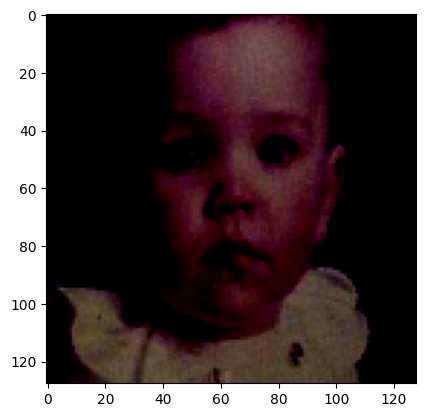

In [27]:
imgplot = plt.imshow(resized_image)
plt.show()

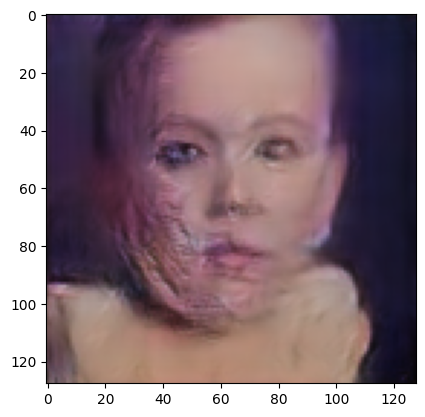

In [28]:
imgplot = plt.imshow(output_image)
plt.show()

1/1 [==============================] - 0s 12ms/step
FAKE A
(1, 128, 128, 3)
1/1 [==============================] - 0s 11ms/step


/tmp/ipykernel_4325/1911275752.py:72: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return imageio.imread(path, mode='RGB').astype(np.float)
/tmp/ipykernel_4325/1911275752.py:72: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return imageio.imread(path, mode='RGB').astype(np.float)


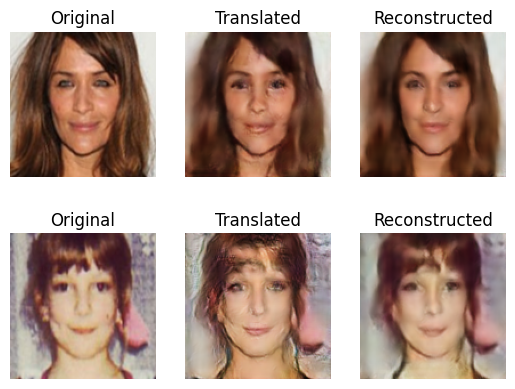

In [29]:
cycle_gan.sample_images(1, 1)